# MNIST callbacks

This example assumes you've read `callbacks/basic.ipynb`, and covers:

  - Creating advanced custom callbacks
  - Using and modifying builtin callbacks
  - Visualization and data gathering callbacks

In [1]:
import os
import sys
import deeptrain
deeptrain.util.misc.append_examples_dir_to_sys_path()  # for `from utils import`
logger_savedir = os.path.join(sys.path[0], "logger")

from utils import make_classifier, init_session, img_labels_paths
from utils import Adam
from utils import CL_CONFIGS as C
from see_rnn import features_2D
import numpy as np

from deeptrain.callbacks import TraingenCallback, TraingenLogger
from deeptrain.callbacks import make_layer_hists_cb

### Data Logger
  - Gathers data throughout training: weights, outputs, and gradients of model layers. 
  - We inherit the base class and override methods where we wish actions to occur: on save, load, and end of train epoch.

In [2]:
class TraingenLoggerCB(TraingenLogger):
    def __init__(self, savedir, configs, **kwargs):
        super().__init__(savedir, configs, **kwargs)

    def on_save(self, stage=None):
        self.save(_id=self.tg.epoch)  # `tg` will be set inside TrainGenerator

    def on_load(self, stage=None):
        self.clear()
        self.load()

    def on_train_epoch_end(self, stage=None):
        self.log()

log_configs = {
    'weights': ['conv2d'],
    'outputs': 'conv2d',
    'gradients': ('conv2d',),
    'outputs-kw': dict(learning_phase=0),
    'gradients-kw': dict(learning_phase=0),
}
tg_logger = TraingenLoggerCB(logger_savedir, log_configs)

### Outputs visuals
 - Plots weights of the second Conv2D layer at end of each epoch.
 - Weights are reshaped such that subplot 'boxes' are output channels.
 - Each box plots flattened spatial dims vertically and input features horizontally.

In [3]:
class ConvWeightsHeatmap(TraingenCallback):
    def on_val_end(self, stage=None):
        if stage == ('val_end', 'train:epoch'):
            self.viz()

    def viz(self):
        w = self.tg.model.layers[2].get_weights()[0]
        w = w.reshape(-1, *w.shape[2:])  # flatten along spatial dims
        w = w.transpose(2, 0, 1)  # (out_features, spatial dims x in_features)

        if not hasattr(self, 'init_norm'):
            # maintain same norm throughout plots for consistency
            mx = np.max(np.abs(w))
            self.init_norm = (-mx, mx)

        features_2D(w, tight=True, w=.4, h=.4, title=None, show_xy_ticks=0,
                    norm=self.init_norm)

cwh = ConvWeightsHeatmap()

Callbacks can also be configured as str-function dict pairs, where str is name of a callback "stage" 
(see `tg._cb_alias after tg.train()`).

In [4]:
kw = {'configs': {'annot': {'fontsize': 11}}}
grad_hists = {'train:epoch': [make_layer_hists_cb(mode='gradients:outputs', **kw),
                              make_layer_hists_cb(mode='gradients:weights', **kw)]}
weight_hists = {('val_end', 'train:epoch'): make_layer_hists_cb(mode='weights', **kw)}

configs = {'title': dict(fontsize=13), 'plot': dict(annot_kw=None), **kw['configs']}
layer_outputs_hists = {'val_end': 
                       make_layer_hists_cb(mode='outputs', configs=configs)}

### Init & train

In [5]:
C['traingen']['callbacks'] = [tg_logger, cwh, grad_hists,
                              weight_hists, layer_outputs_hists]
C['traingen']['epochs'] = 4
C['traingen']['iter_verbosity'] = 0
C['traingen']['plot_configs'] = {'0': {'legend_kw': {'fontsize': 11}}}
C['datagen']['labels_path']     = img_labels_paths[0]
C['val_datagen']['labels_path'] = img_labels_paths[1]
C['model']['optimizer'] = Adam(1e-2)
tg = init_session(C, make_classifier)

Discovered 48 files with matching format
Discovered dataset with matching format
48 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated

Discovered 36 files with matching format
Discovered dataset with matching format
36 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated

Preloading superbatch ... Discovered 48 files with matching format
................................................ finished, w/ 6144 total samples
Train initial data prepared
Preloading superbatch ... Discovered 36 files with matching format
.................................... finished, w/ 4608 total samples
Val initial data prepared
Logging ON; directory (new): C:\deeptrain\examples\dir\logs\M2__model-Adam__min999.000



Data set_nums shuffled


_____________________
 EPOCH 1 -- COMPLETE 



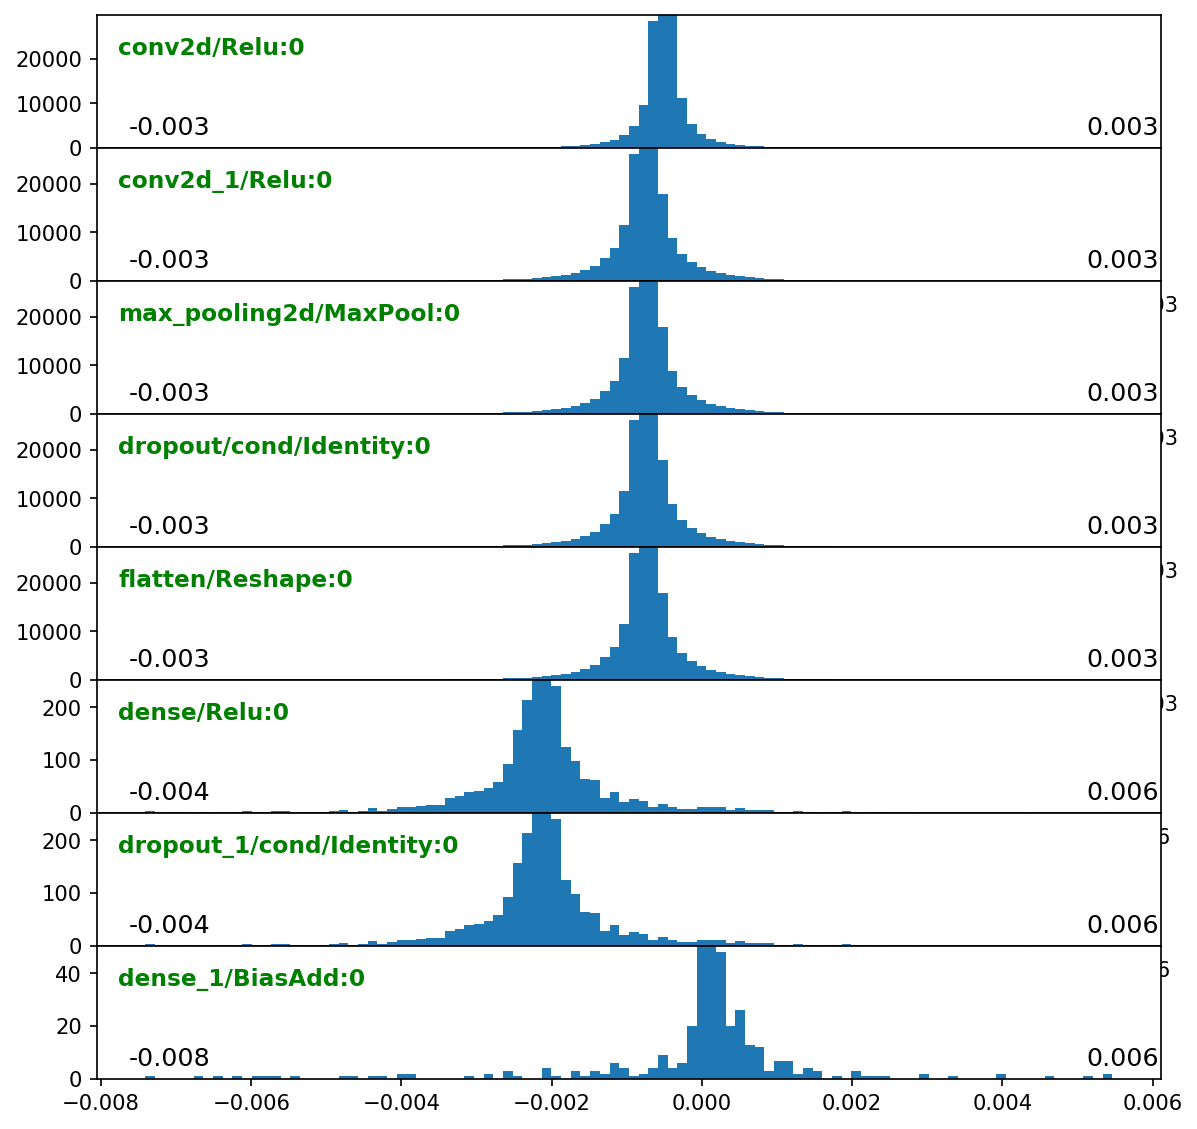

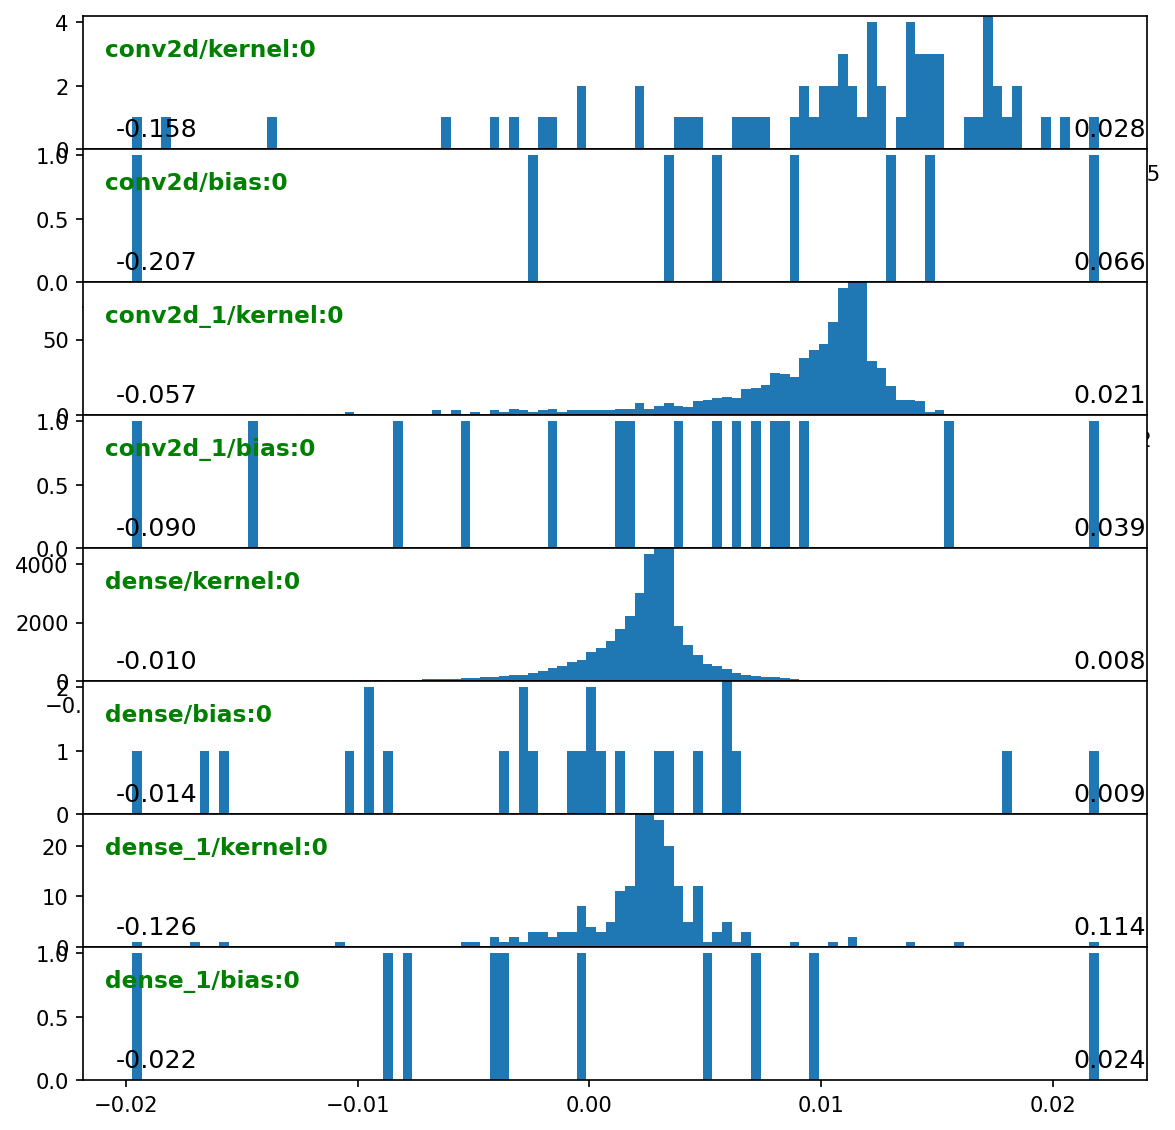



Validating...
TraingenLogger data saved to C:\deeptrain\examples\dir\logger\datalog_1.h5
TrainGenerator state saved
Model report generated and saved
Best model saved to C:\deeptrain\examples\dir\models\M2__model-Adam__min.269
TraingenLogger data saved to C:\deeptrain\examples\dir\logger\datalog_1.h5
TrainGenerator state saved
Model report generated and saved


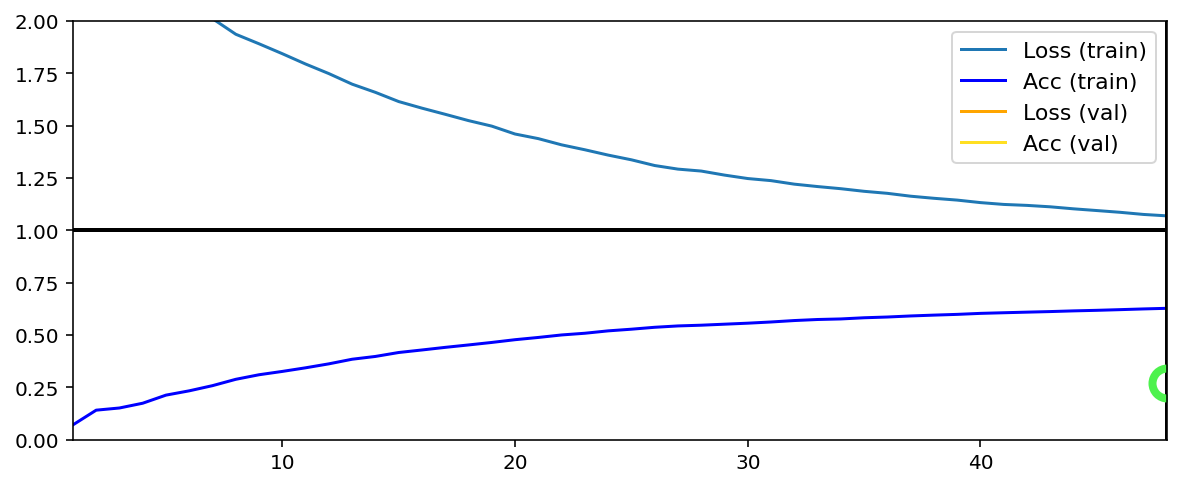

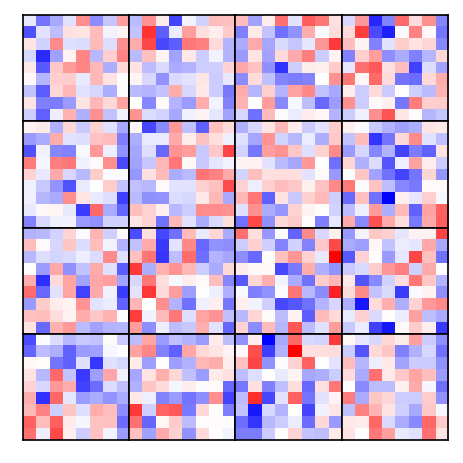

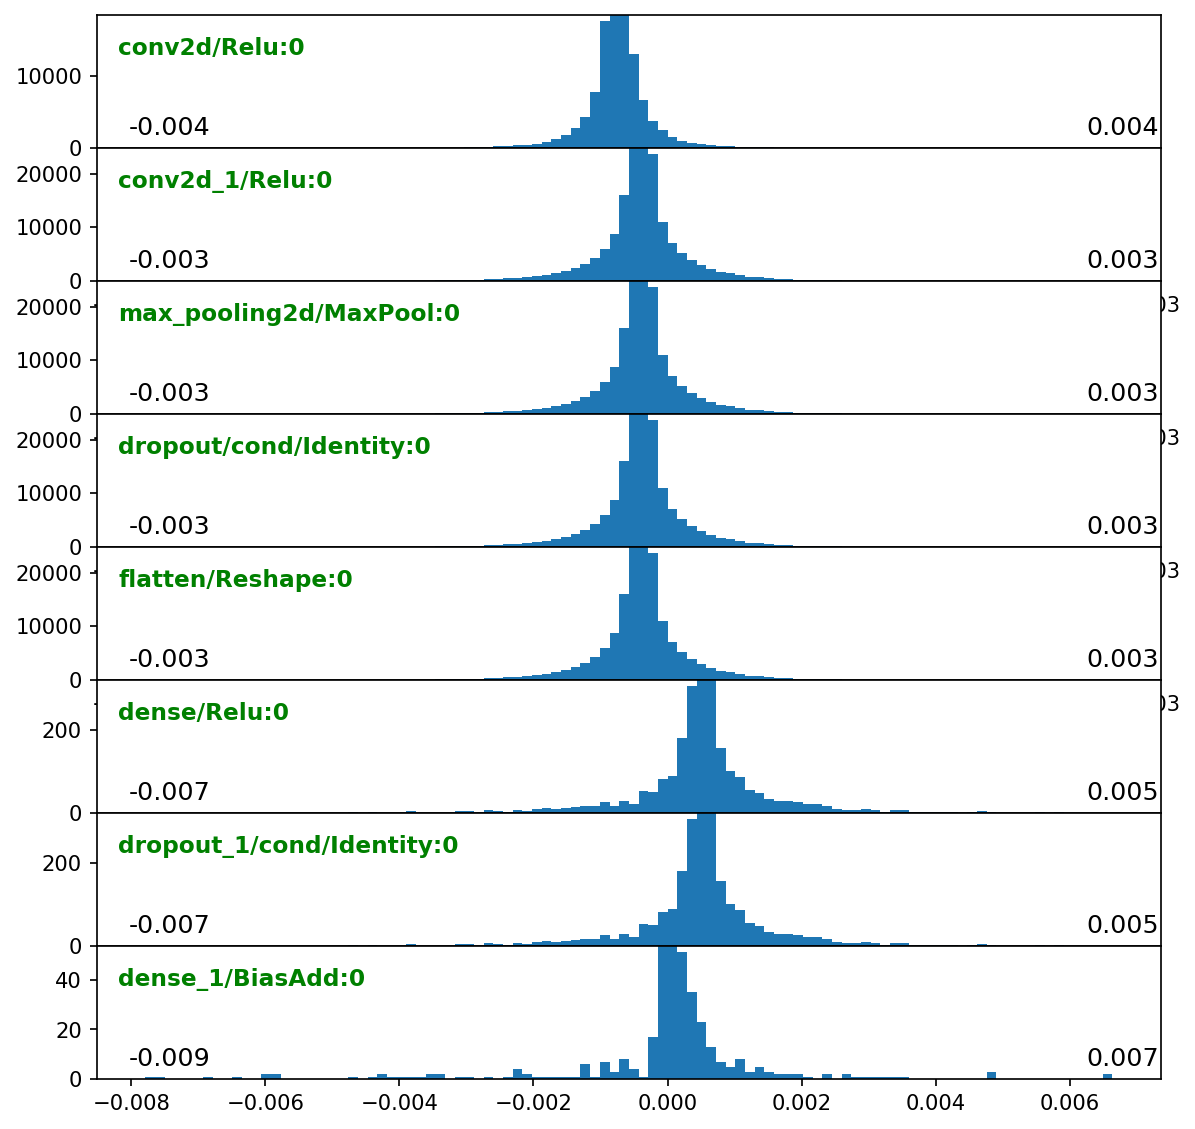

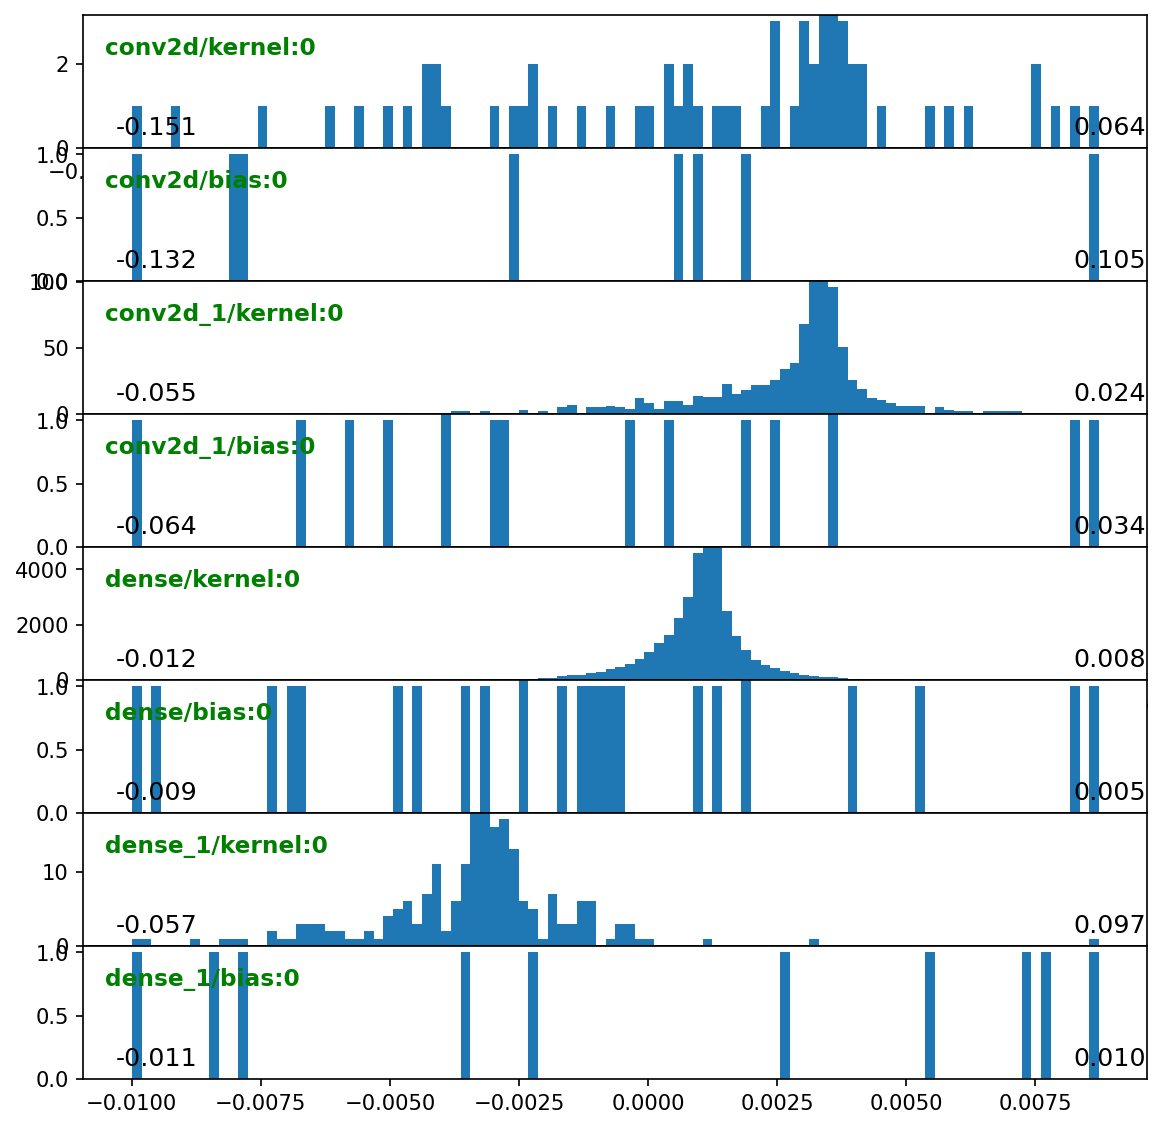

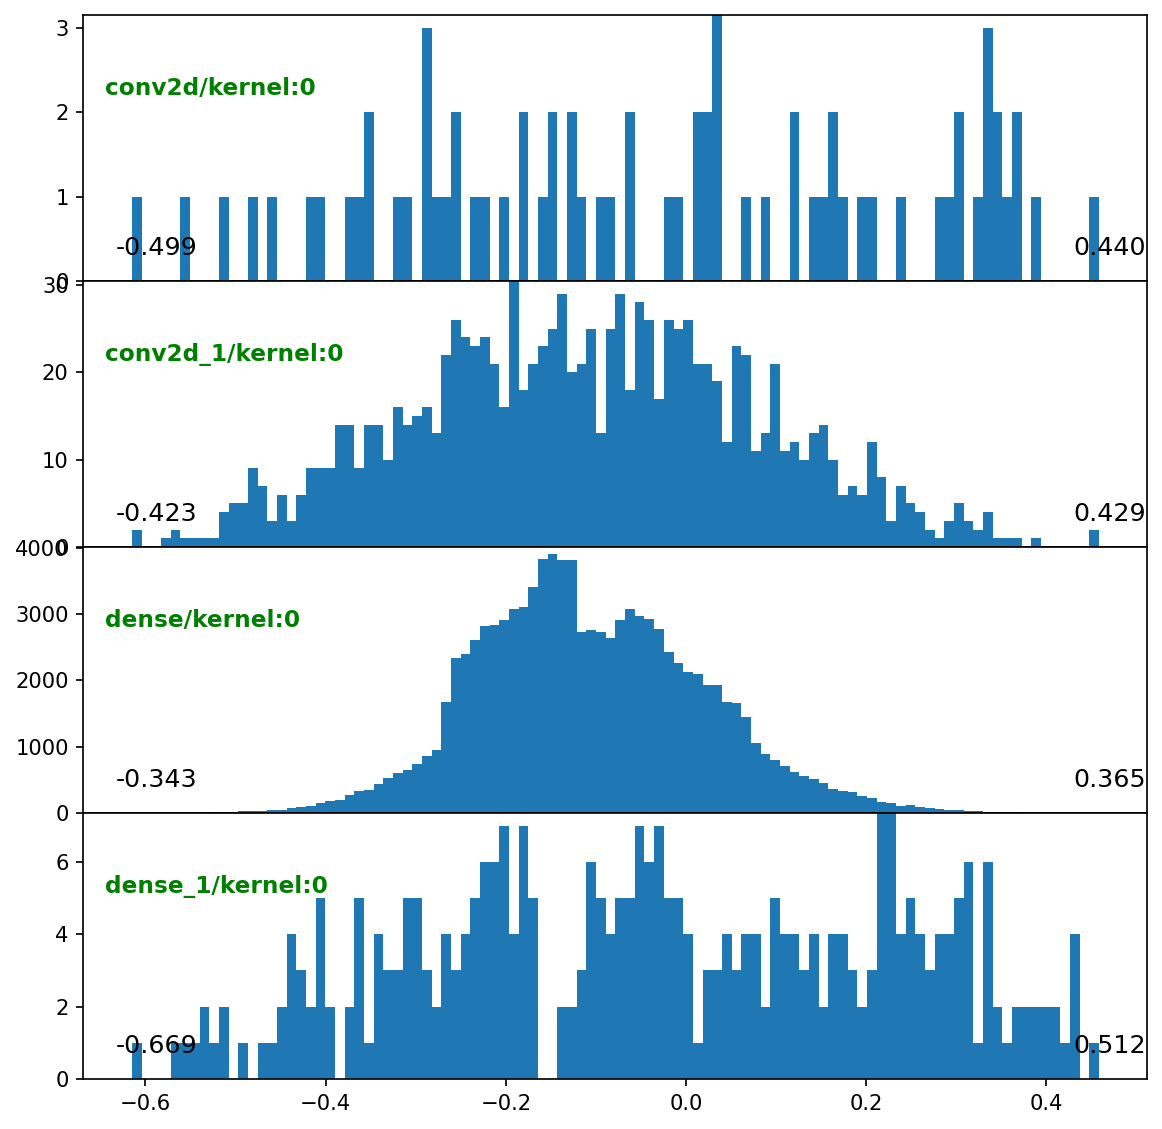

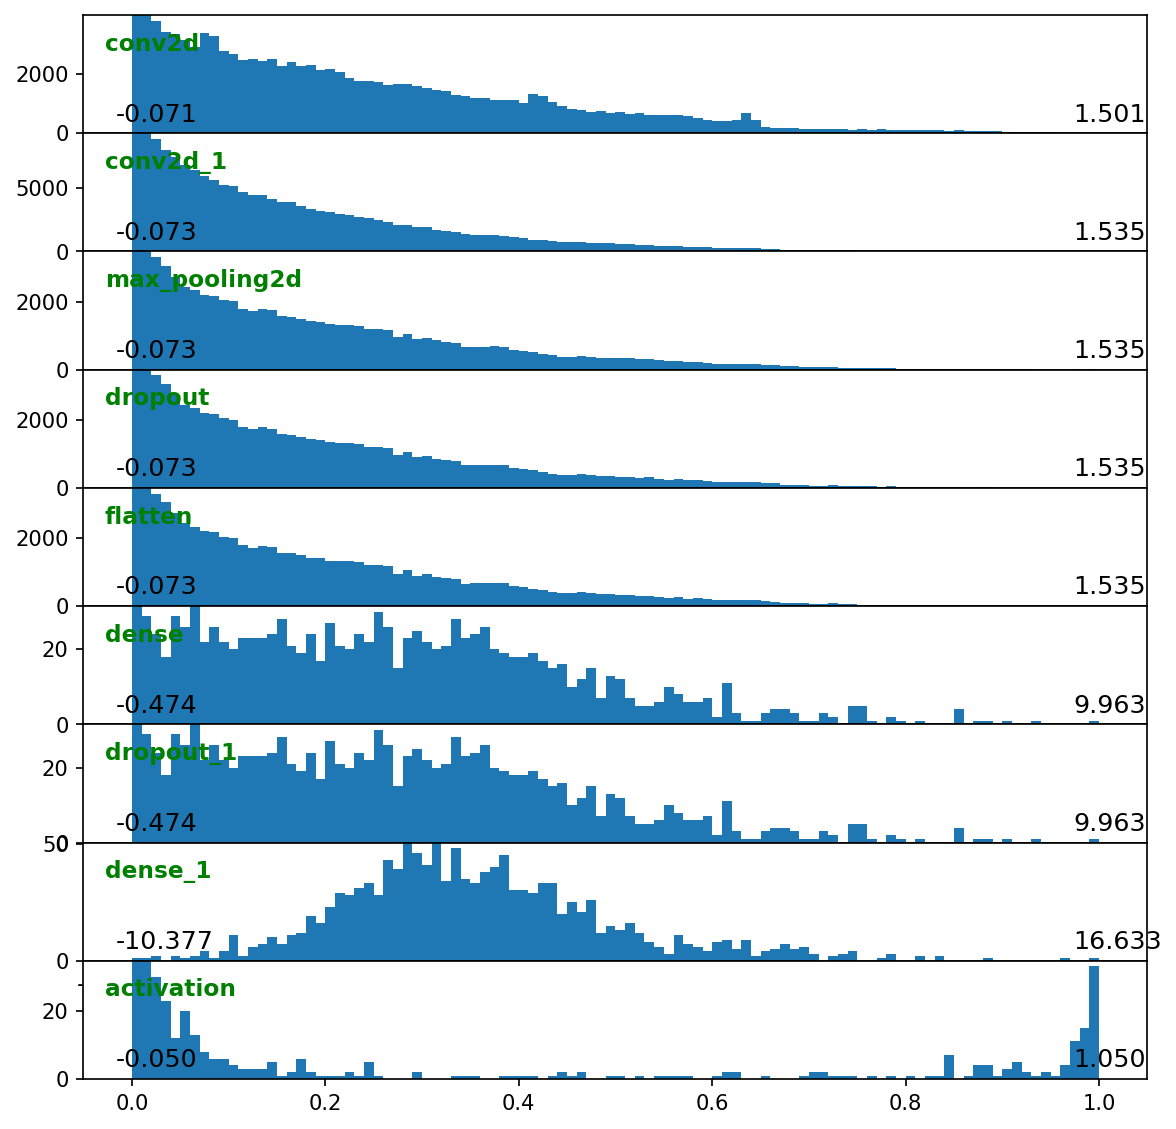


Data set_nums shuffled


_____________________
 EPOCH 2 -- COMPLETE 



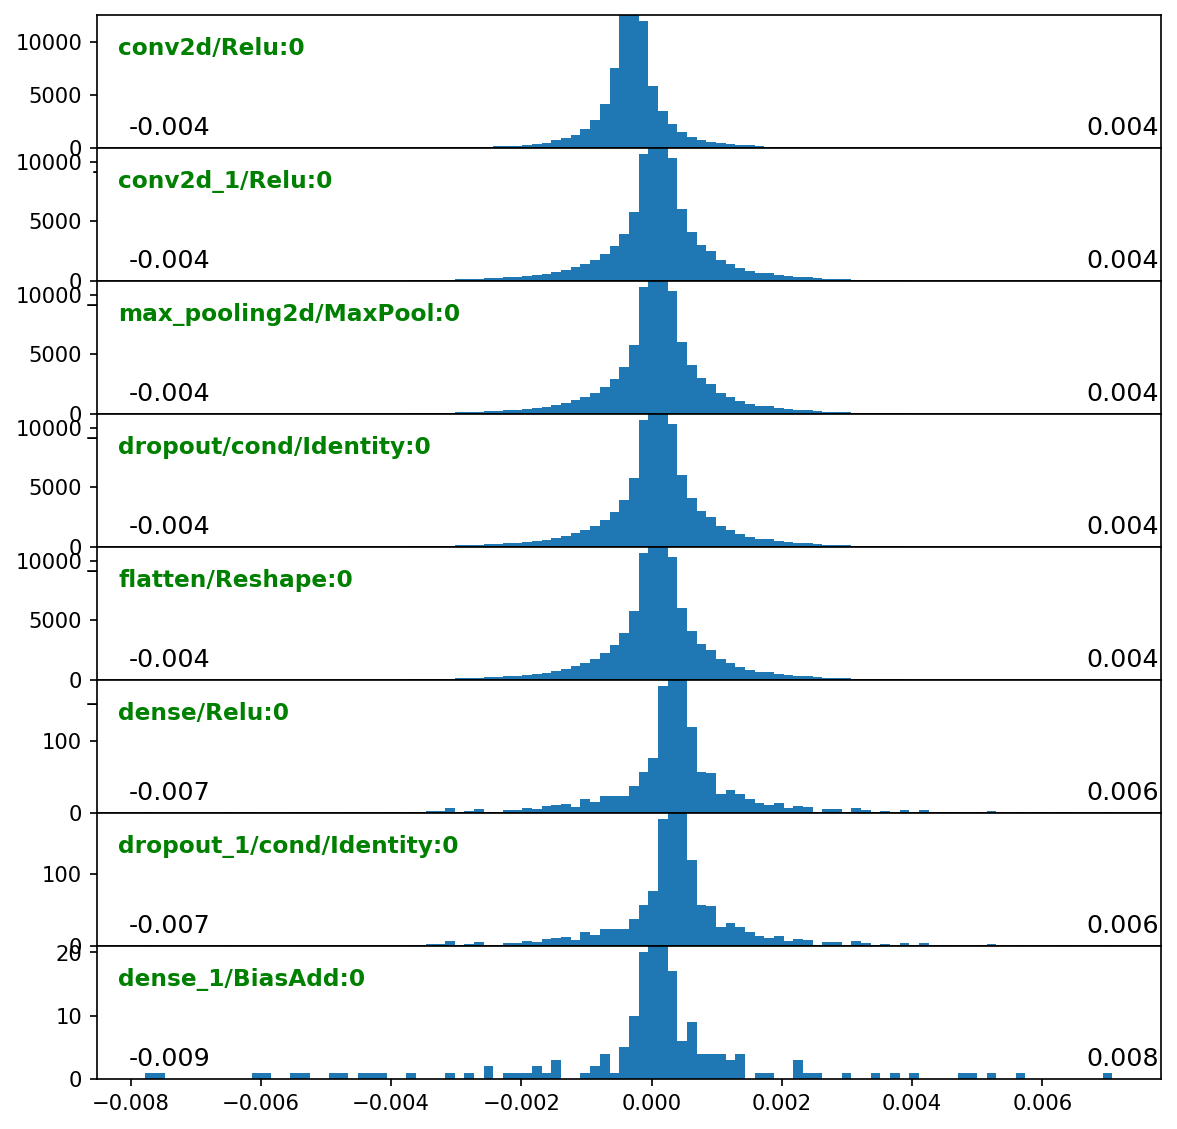

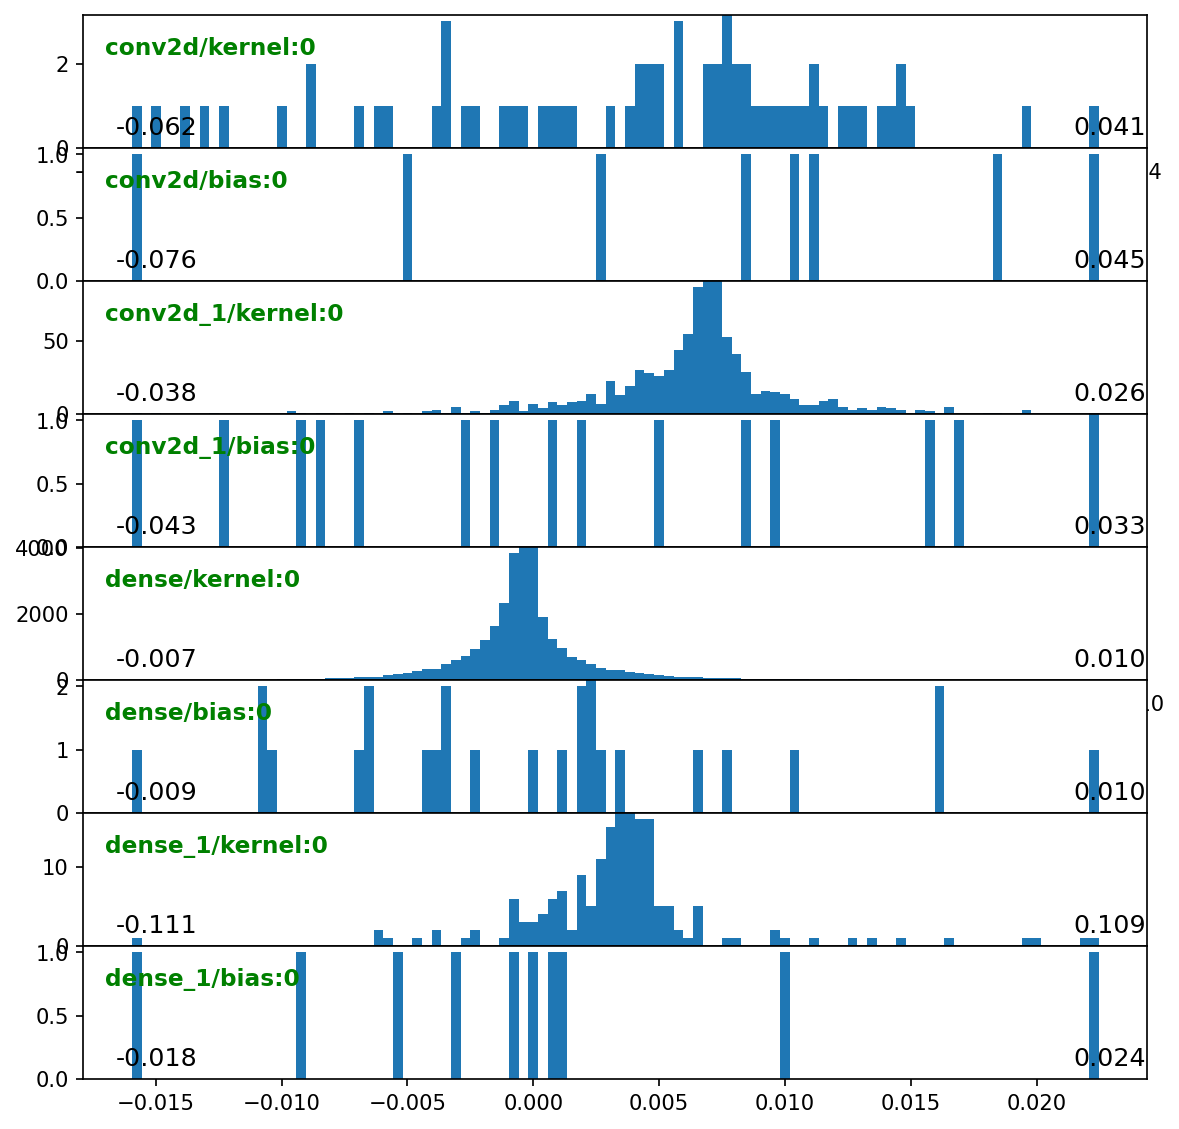



Validating...
TraingenLogger data saved to C:\deeptrain\examples\dir\logger\datalog_2.h5
TrainGenerator state saved
Model report generated and saved
Best model saved to C:\deeptrain\examples\dir\models\M2__model-Adam__min.170
TraingenLogger data saved to C:\deeptrain\examples\dir\logger\datalog_2.h5
TrainGenerator state saved
Model report generated and saved


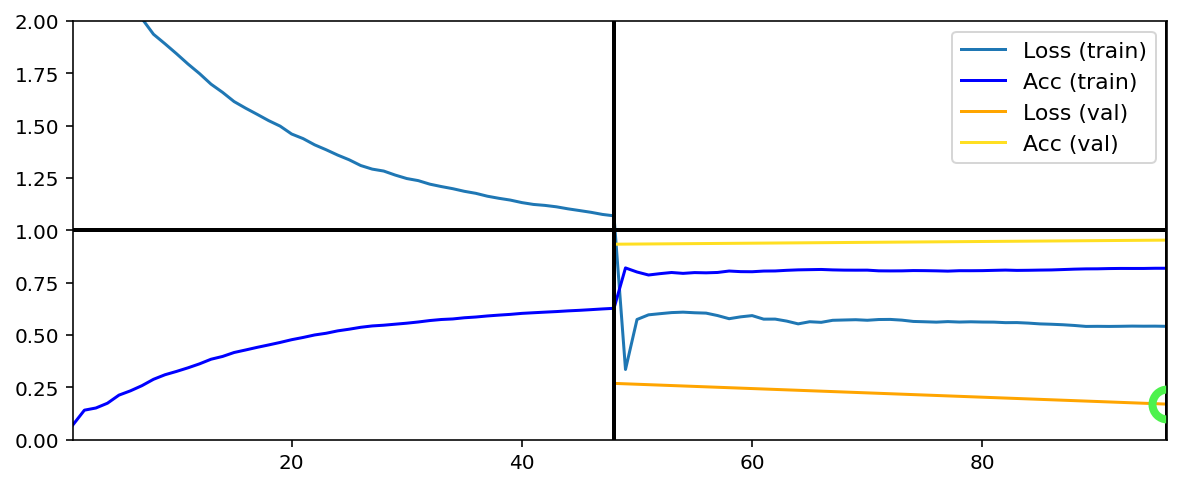

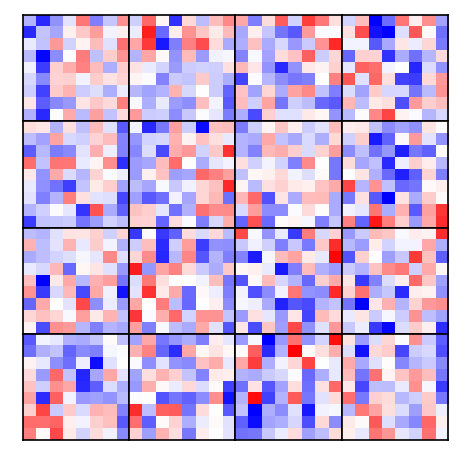

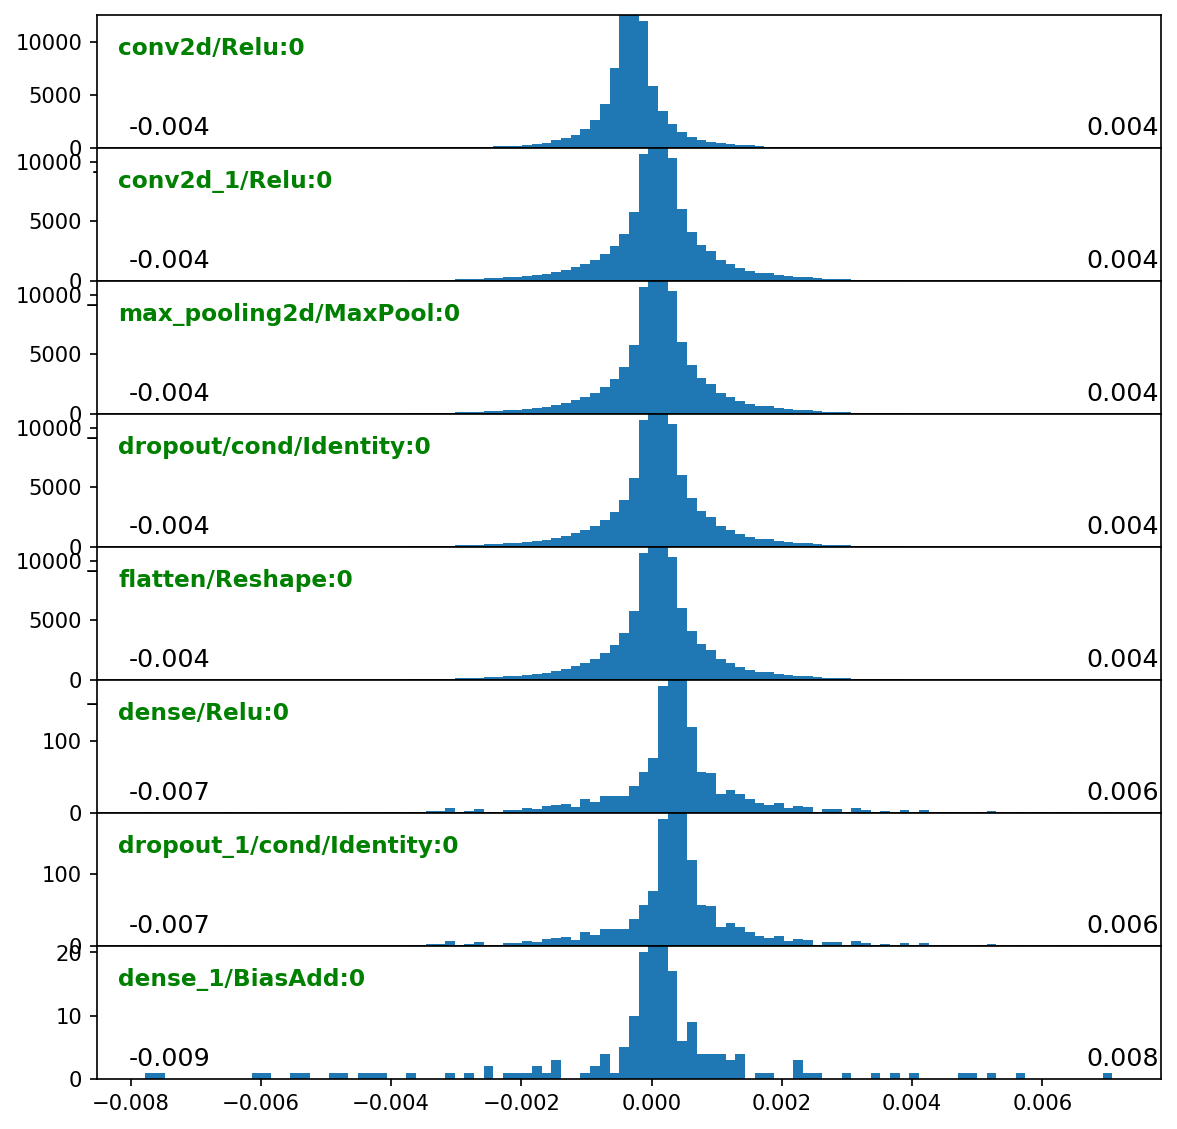

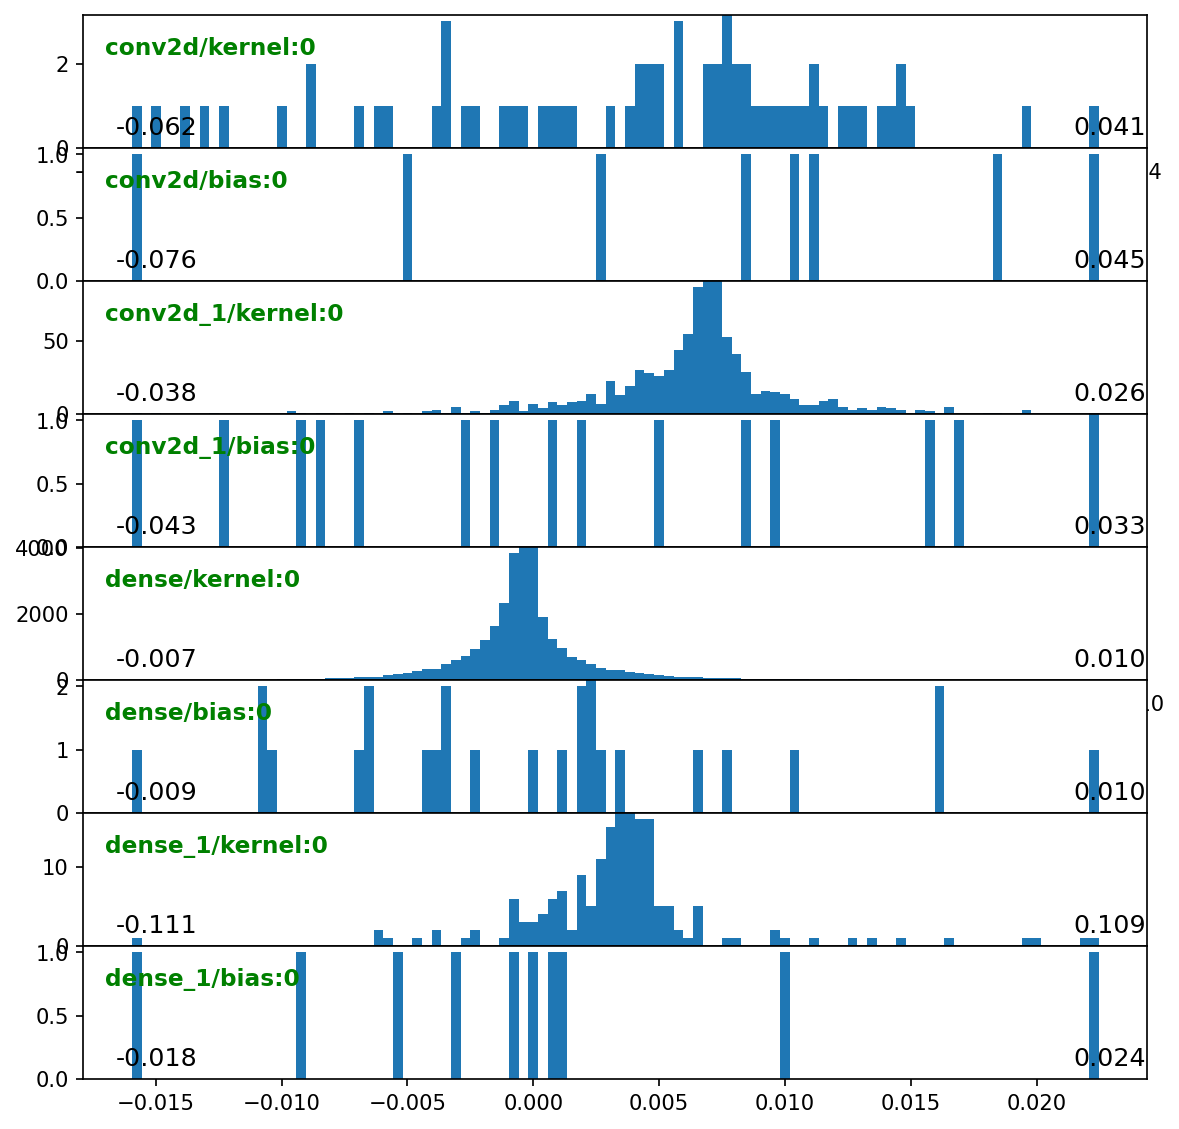

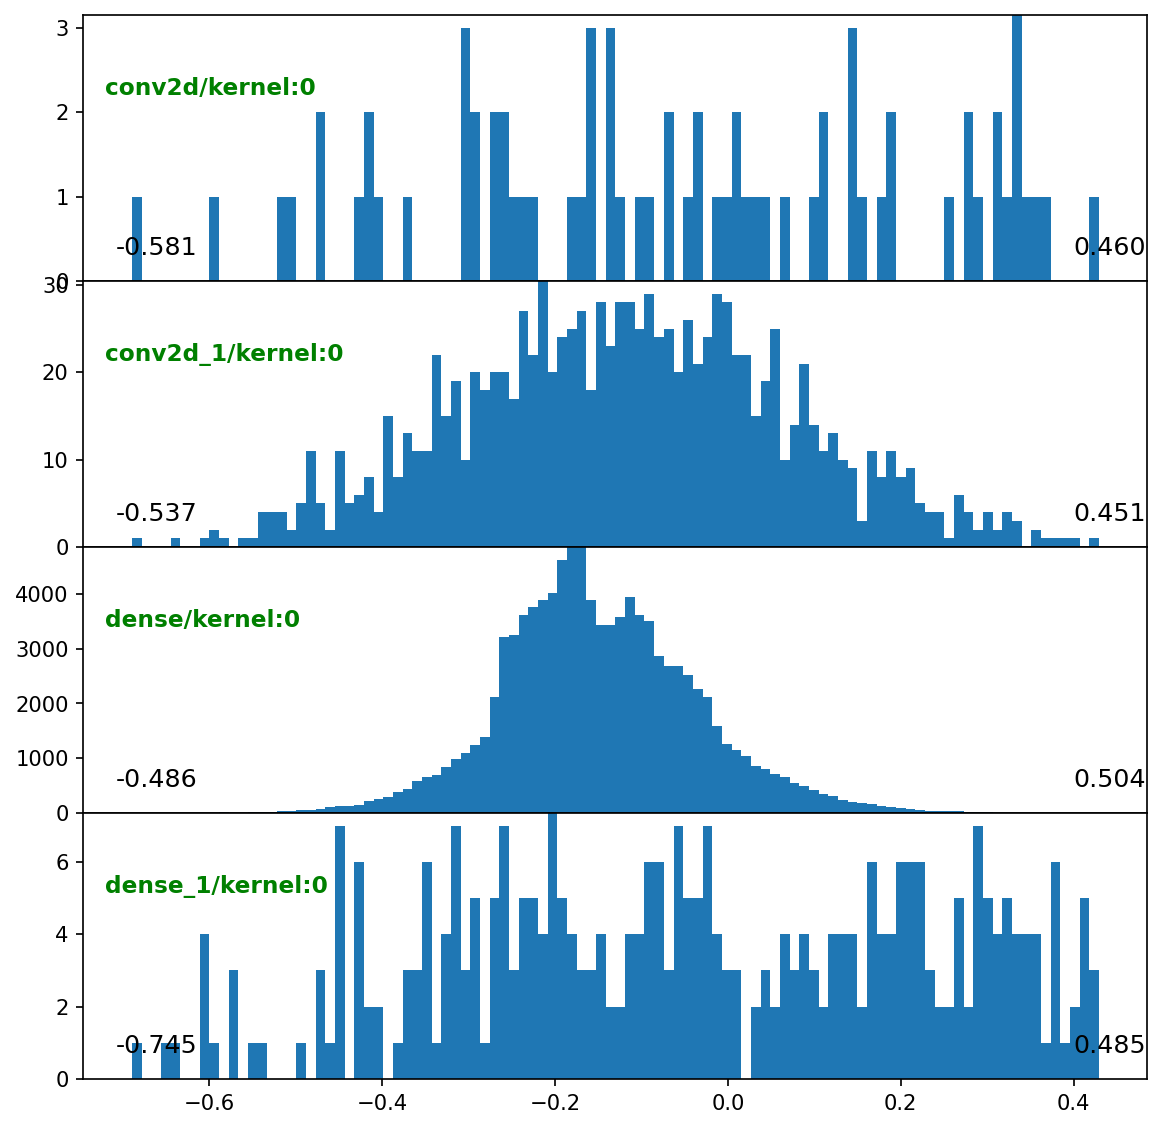

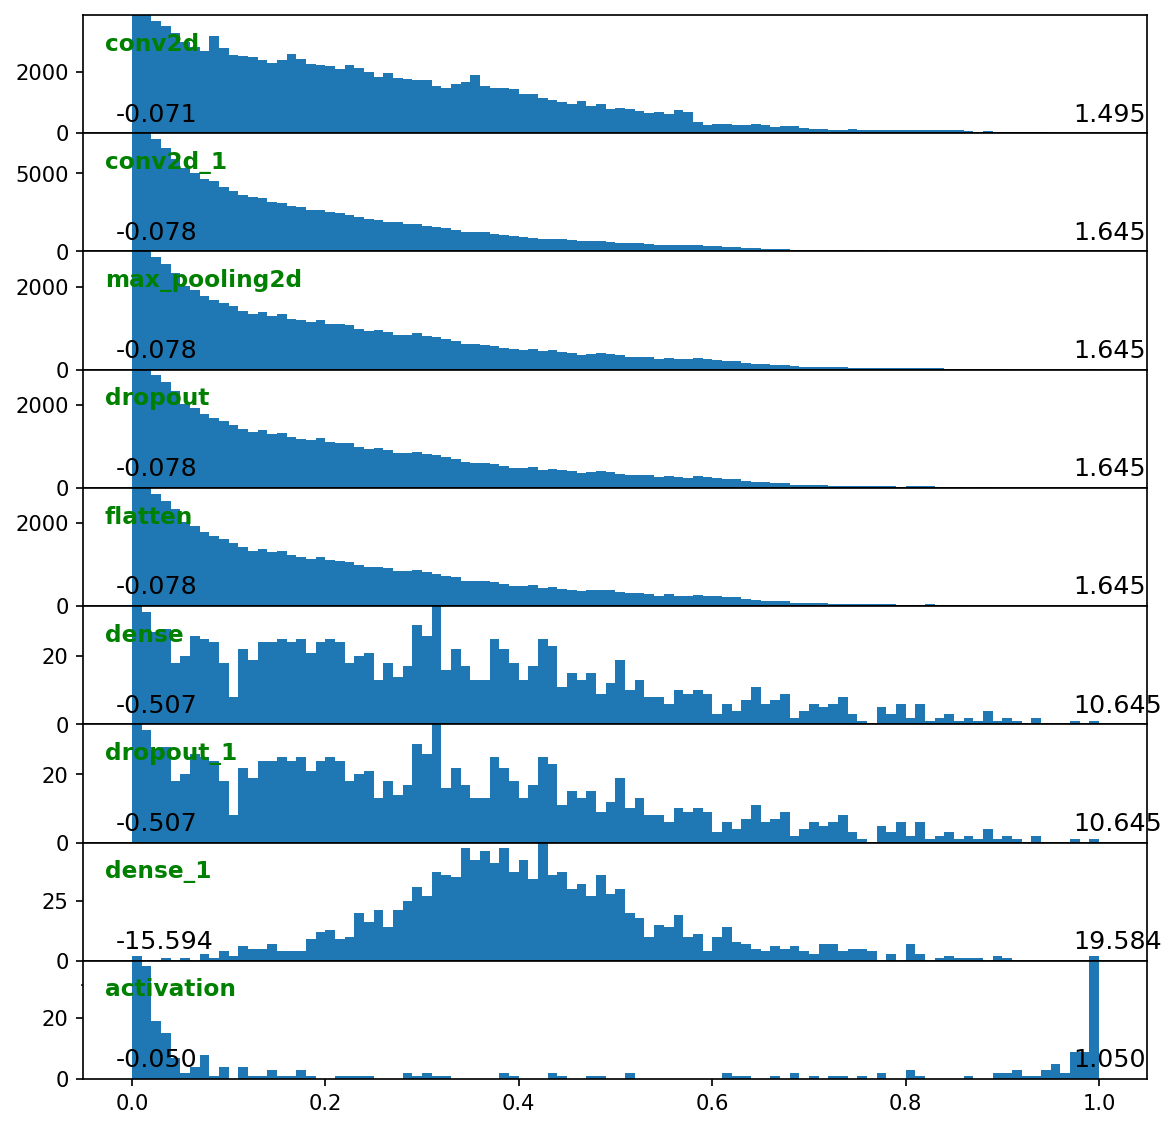


Data set_nums shuffled


_____________________
 EPOCH 3 -- COMPLETE 



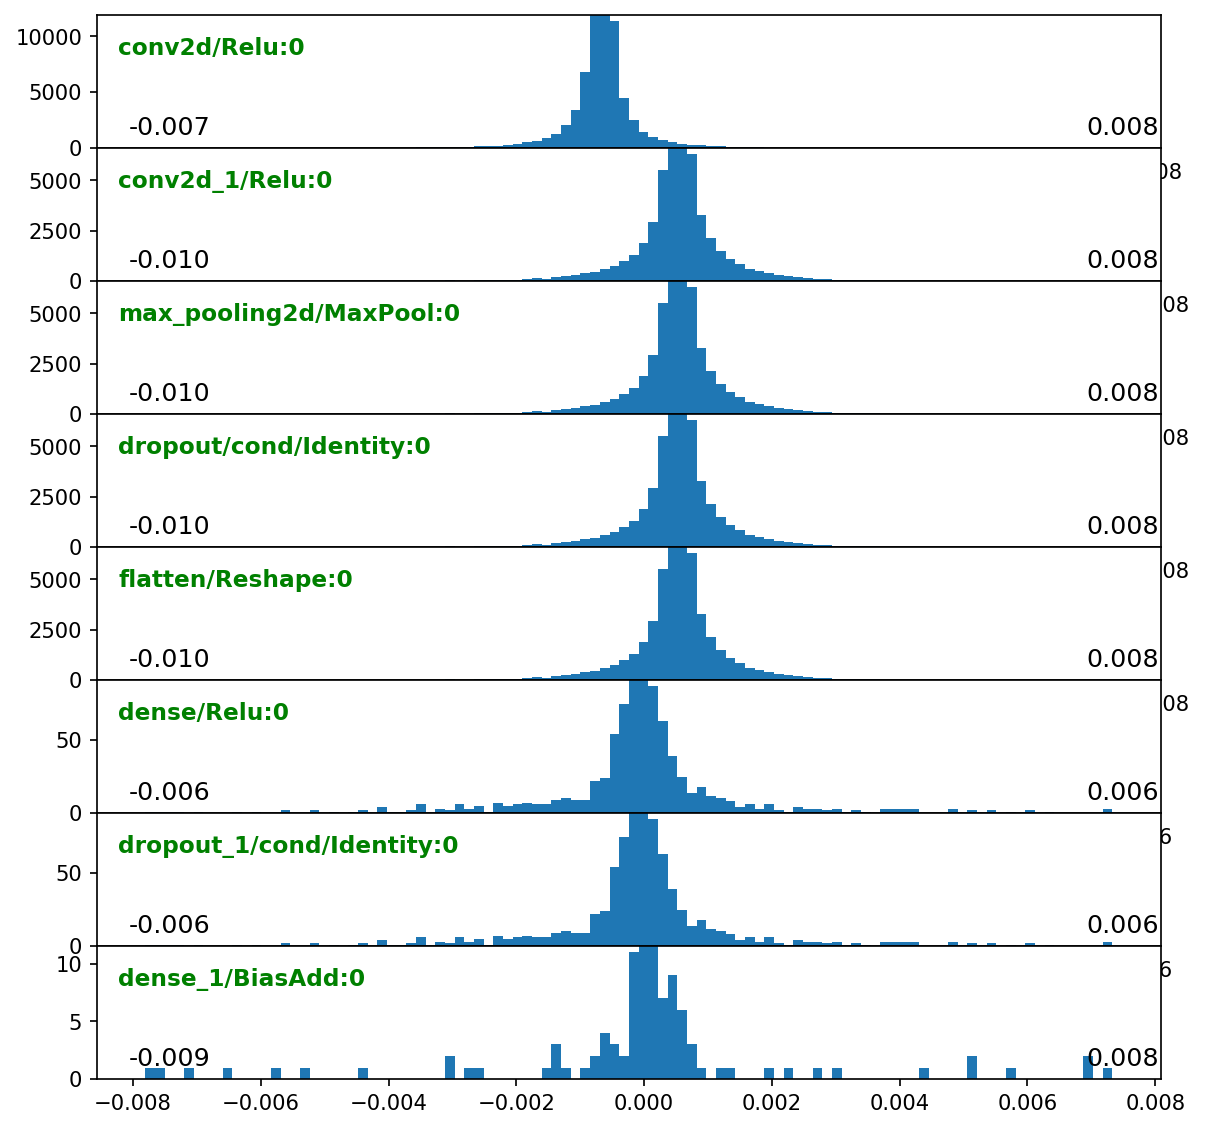

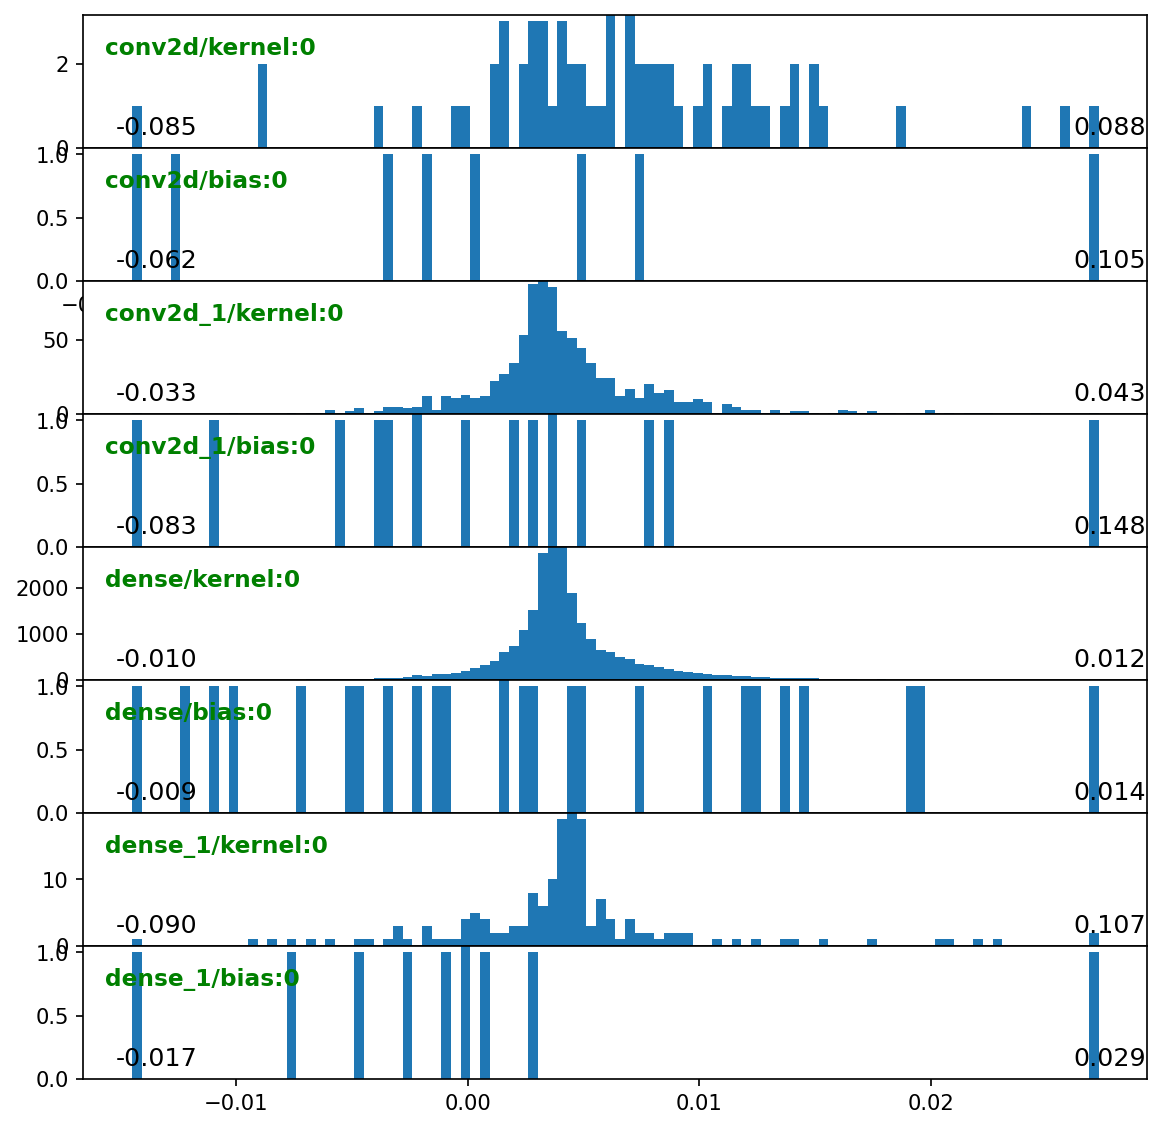



Validating...
TraingenLogger data saved to C:\deeptrain\examples\dir\logger\datalog_3.h5
TrainGenerator state saved
Model report generated and saved
Best model saved to C:\deeptrain\examples\dir\models\M2__model-Adam__min.141
TraingenLogger data saved to C:\deeptrain\examples\dir\logger\datalog_3.h5
TrainGenerator state saved
Model report generated and saved


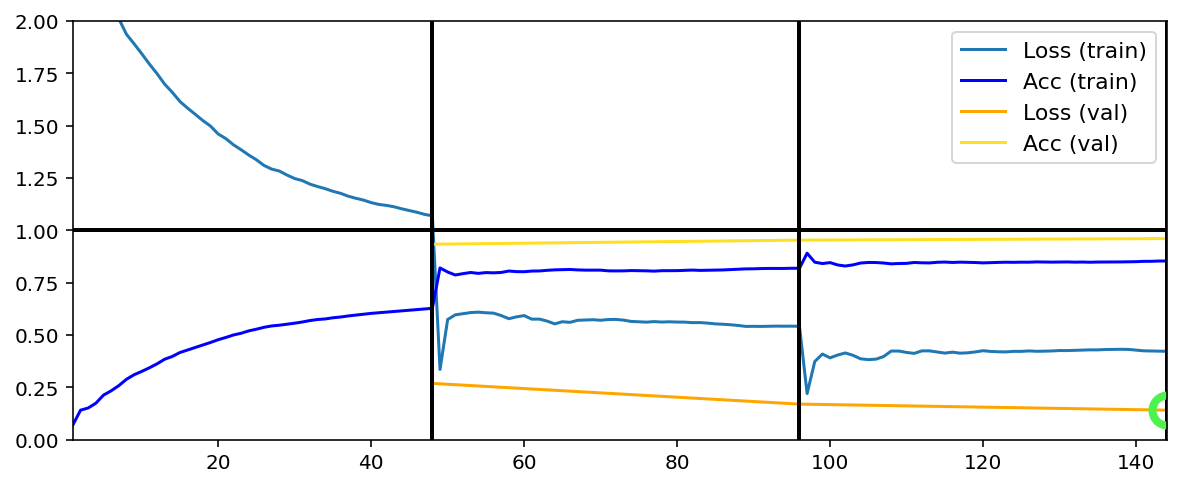

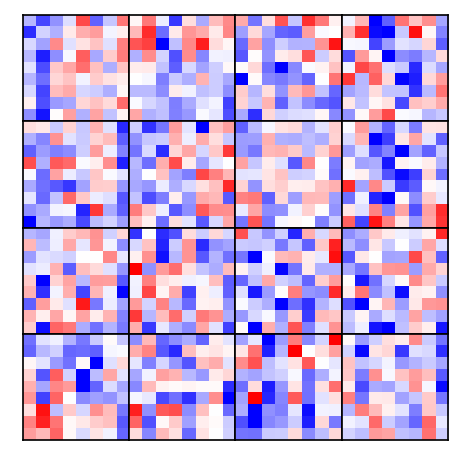

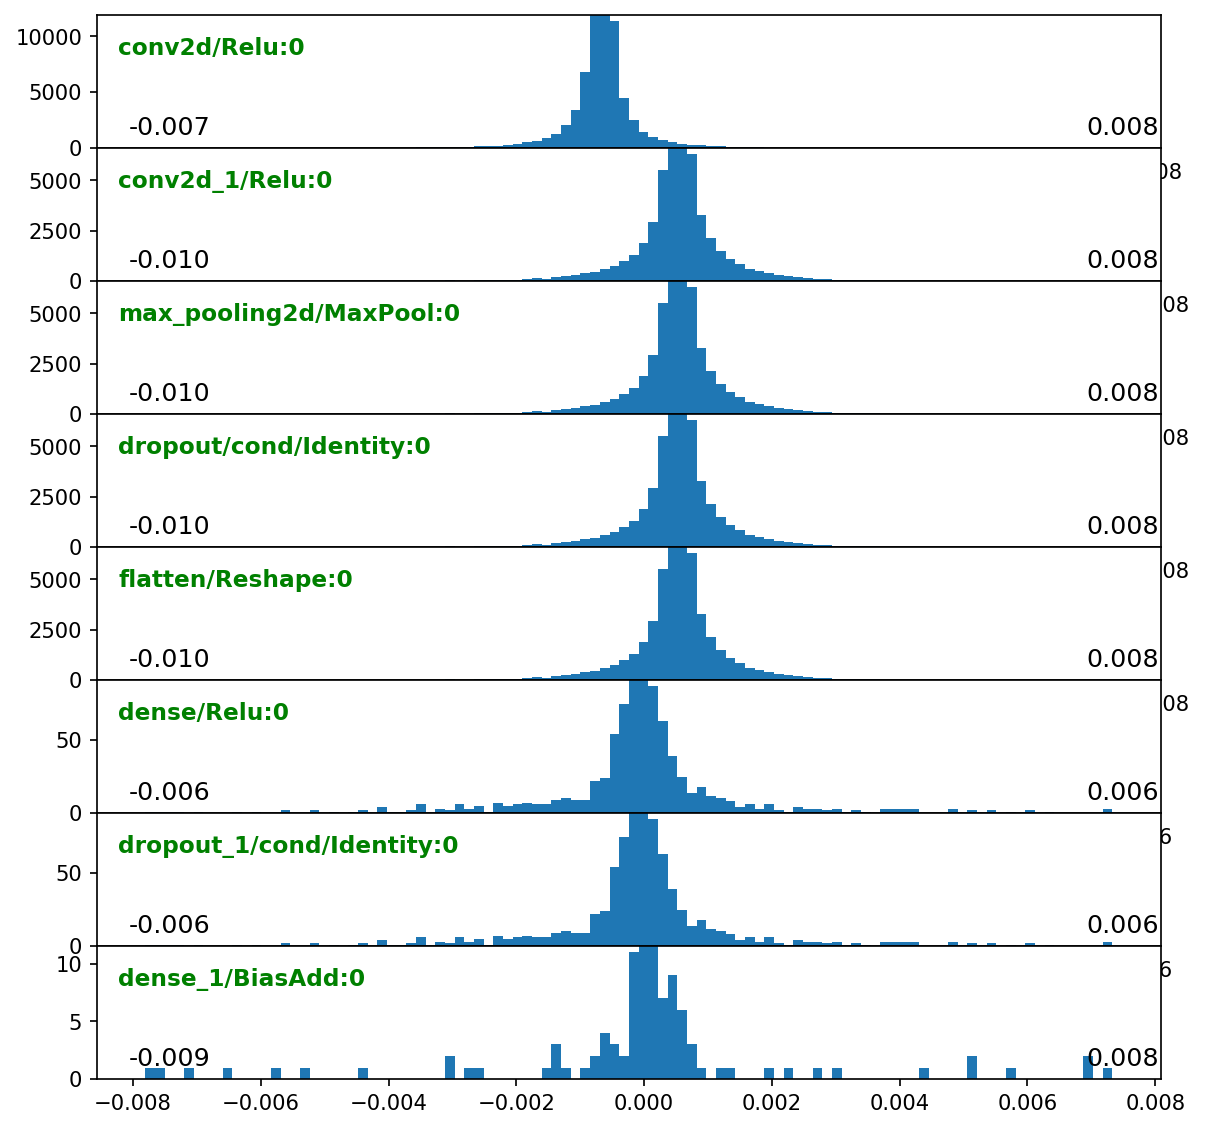

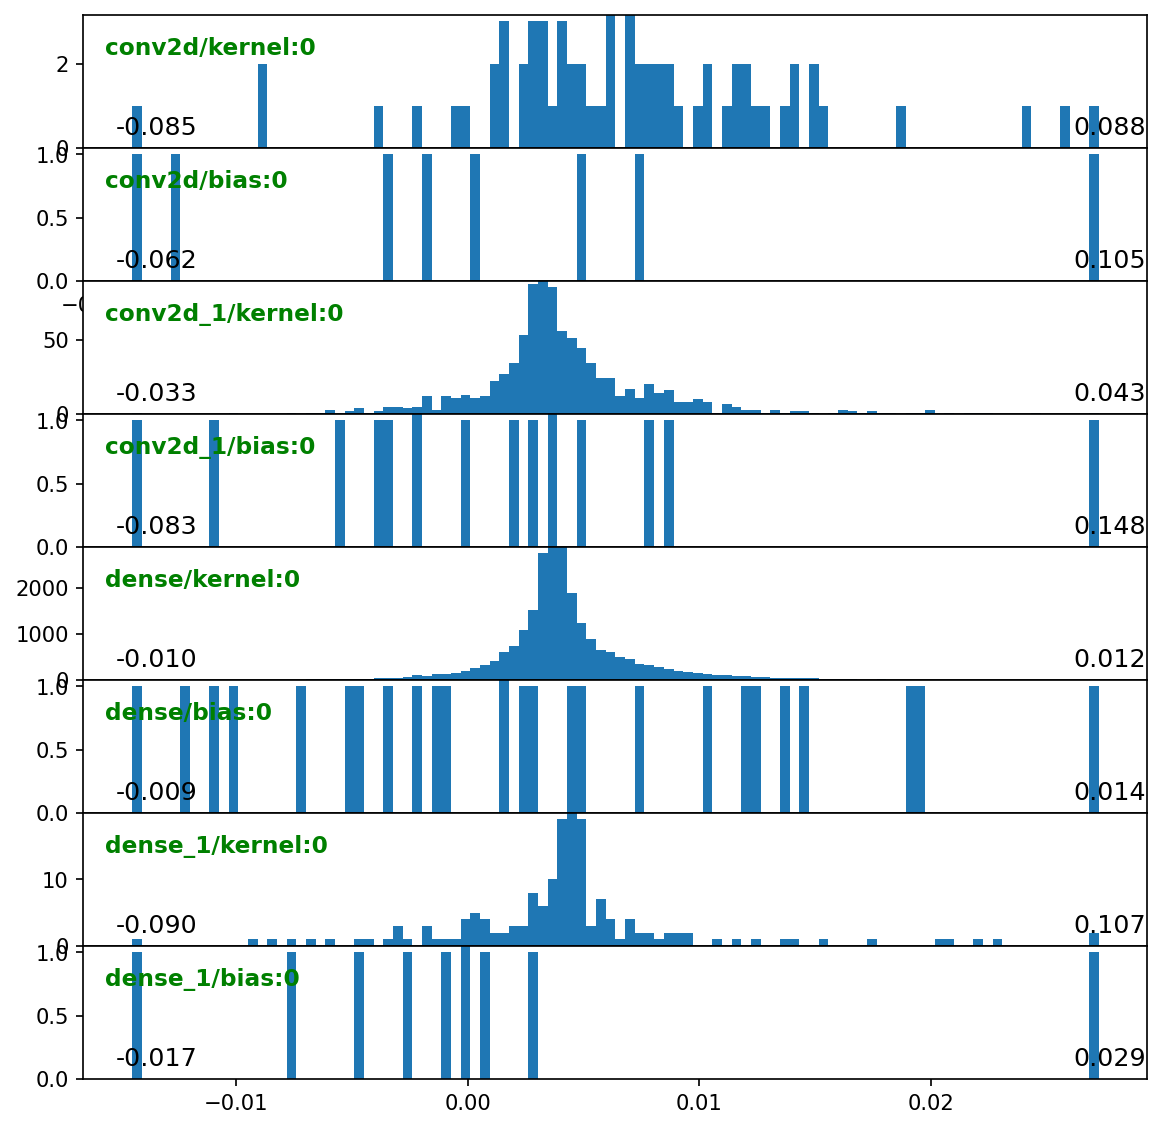

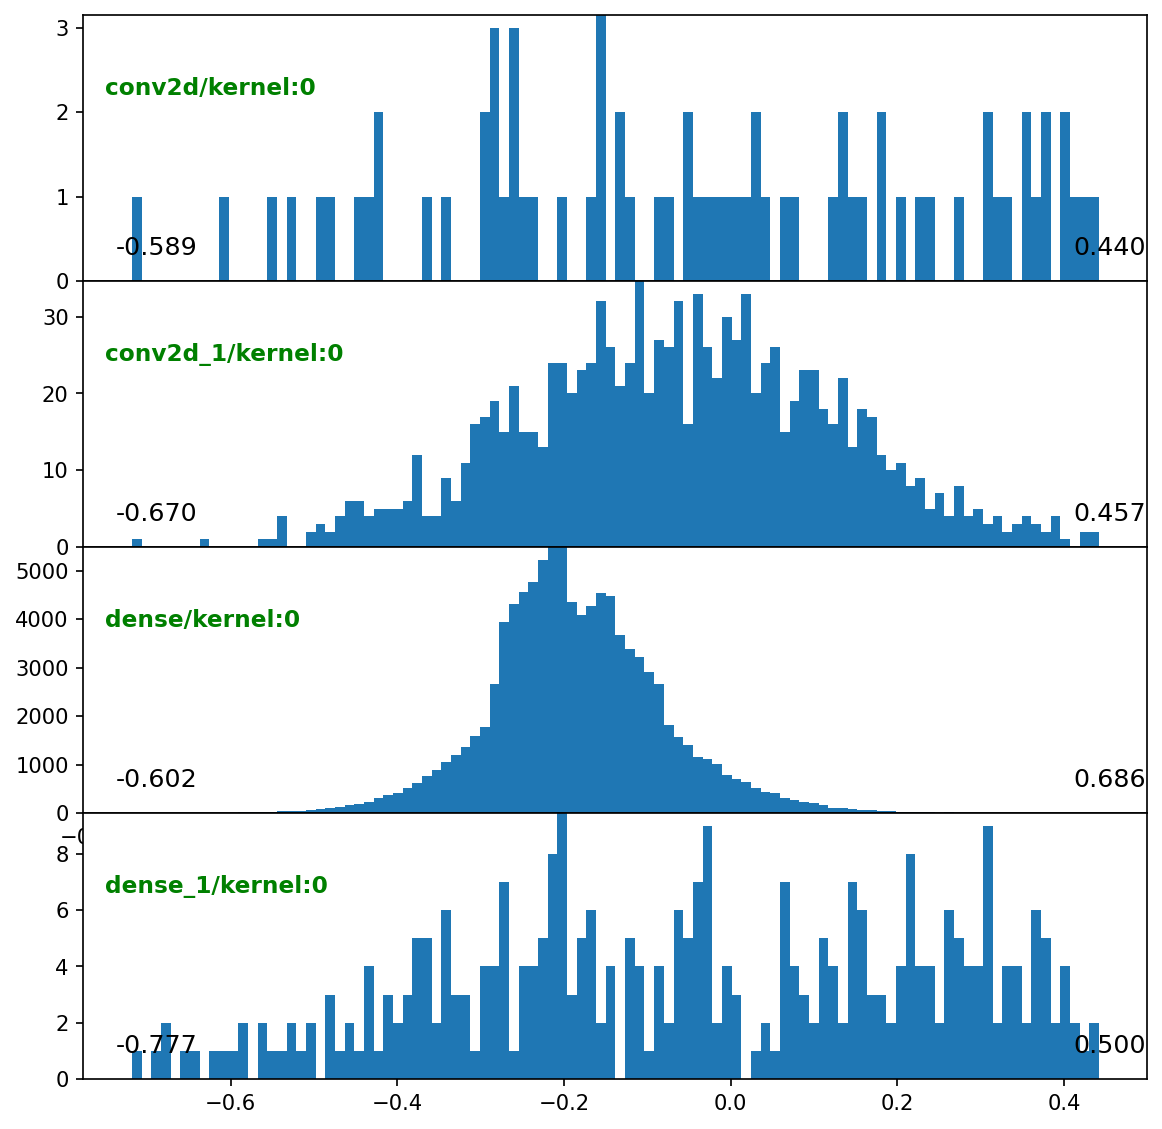

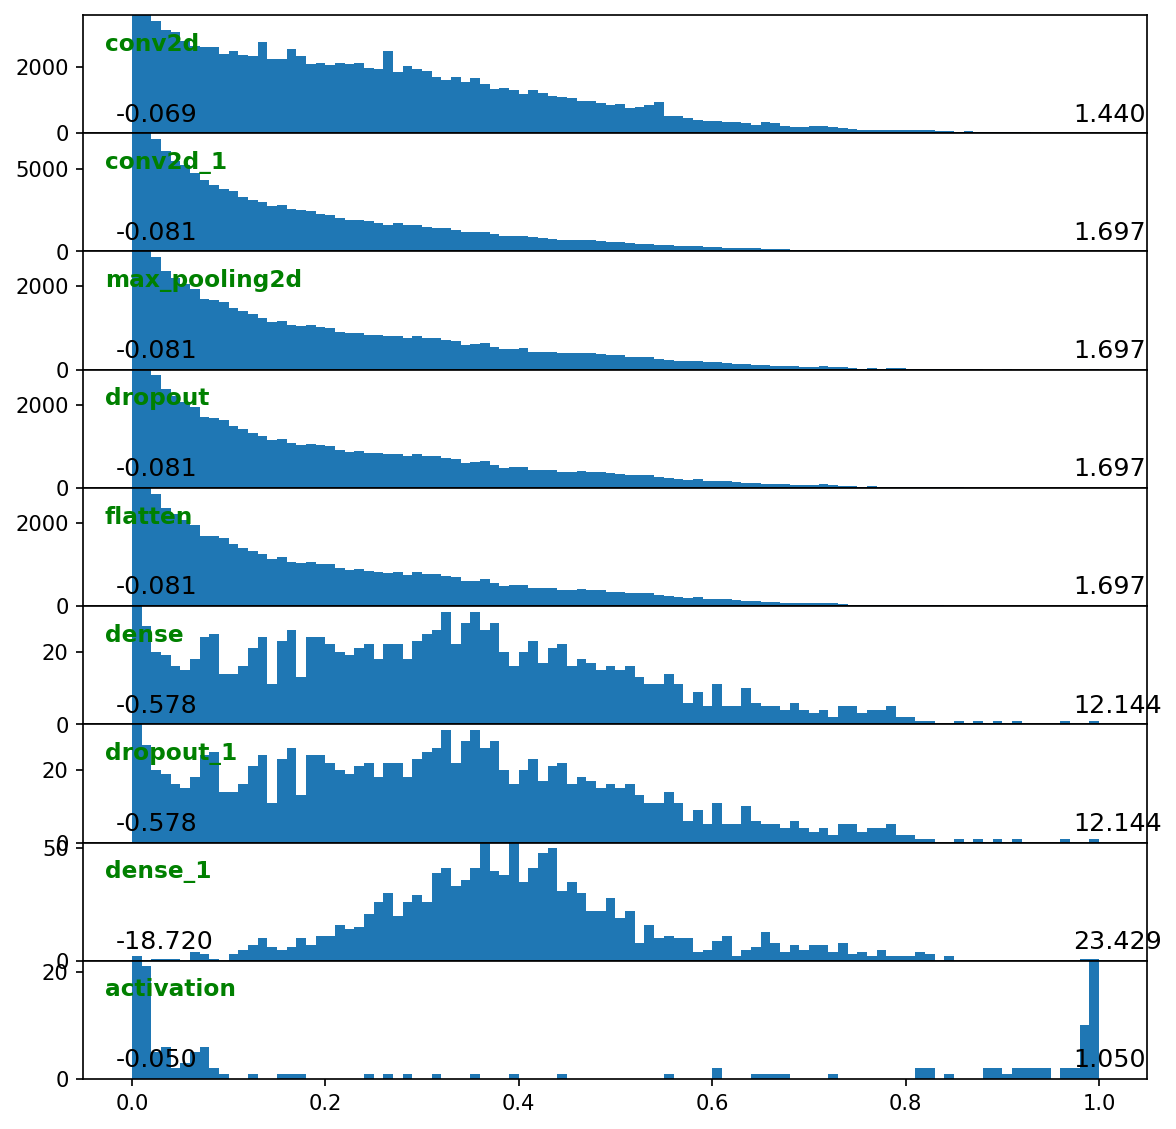


Data set_nums shuffled


_____________________
 EPOCH 4 -- COMPLETE 



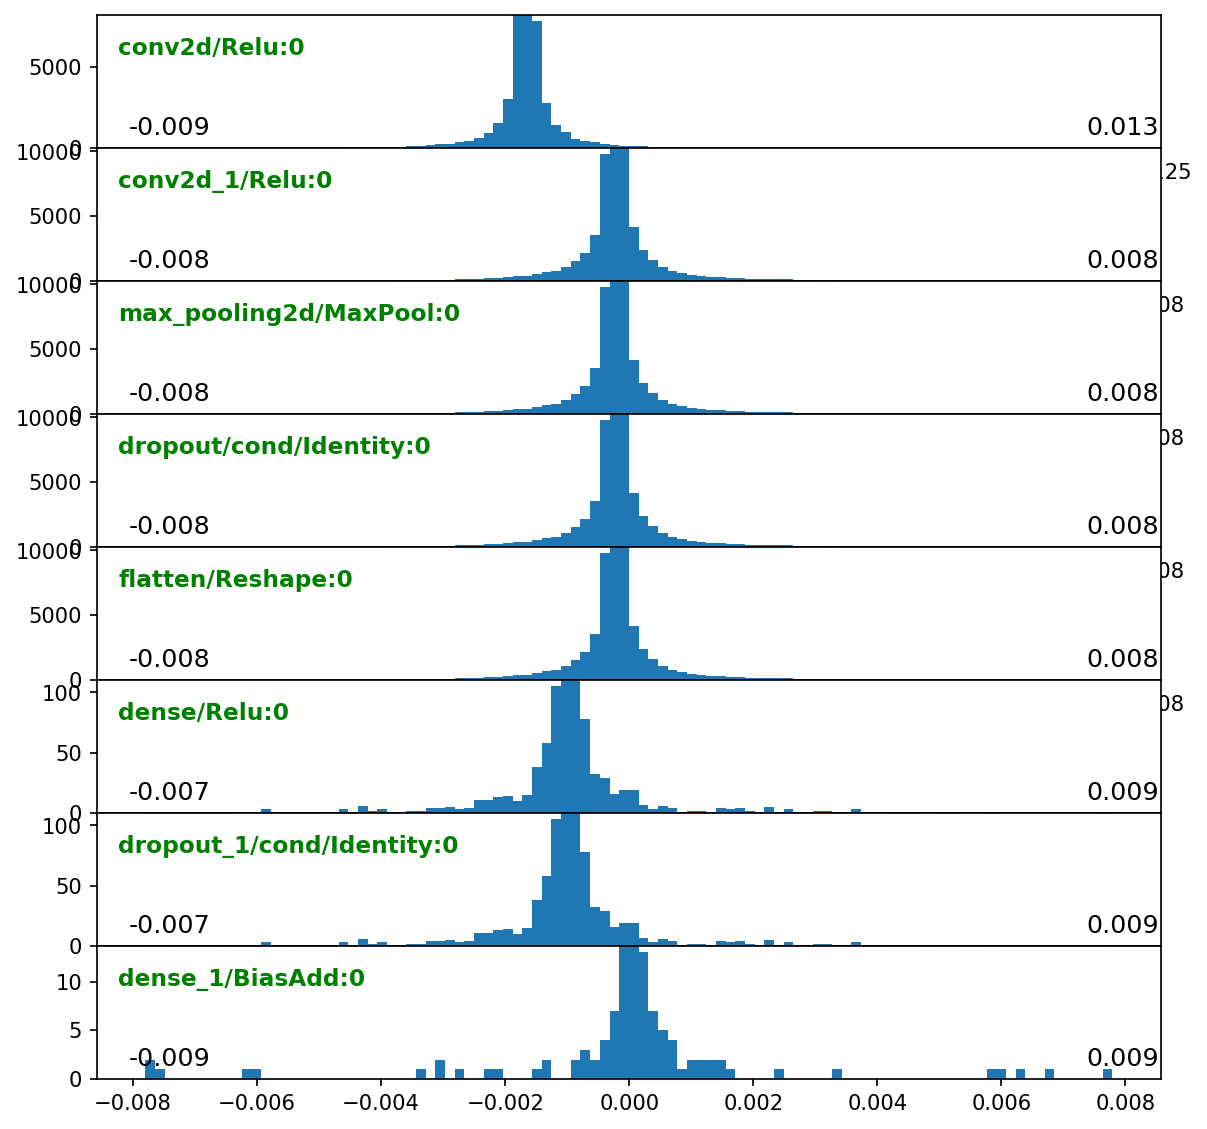

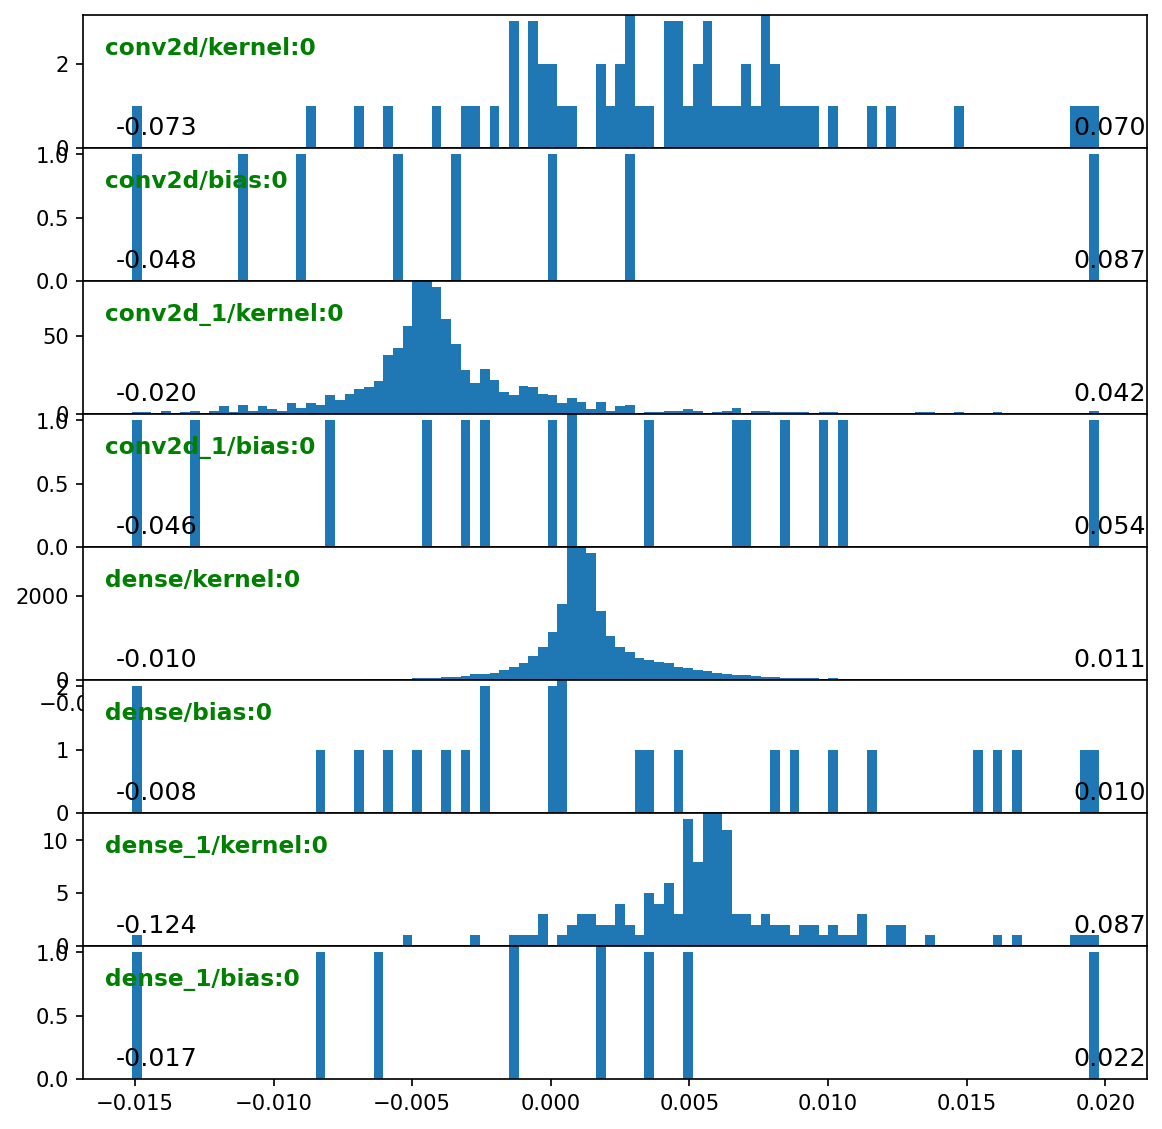



Validating...
TraingenLogger data saved to C:\deeptrain\examples\dir\logger\datalog_4.h5
TrainGenerator state saved
Model report generated and saved
Best model saved to C:\deeptrain\examples\dir\models\M2__model-Adam__min.126
TraingenLogger data saved to C:\deeptrain\examples\dir\logger\datalog_4.h5
TrainGenerator state saved
Model report generated and saved


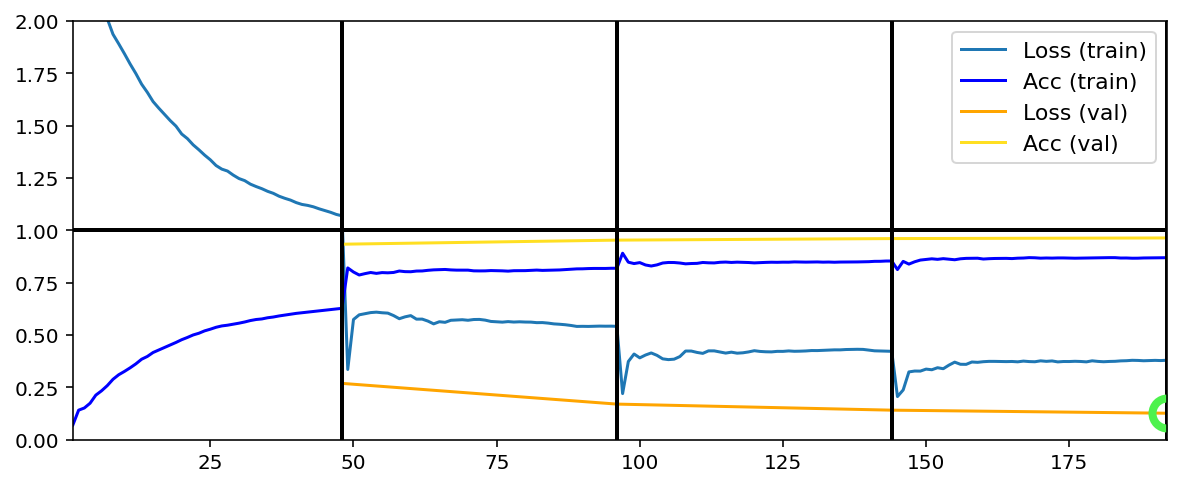

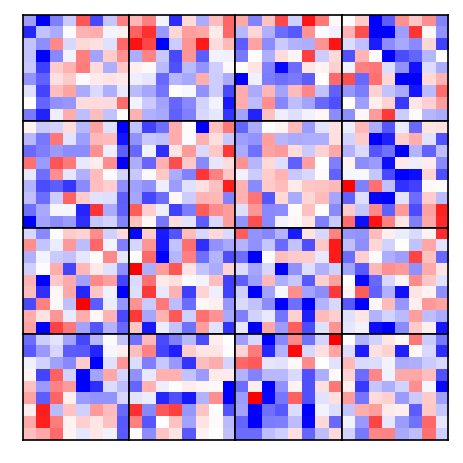

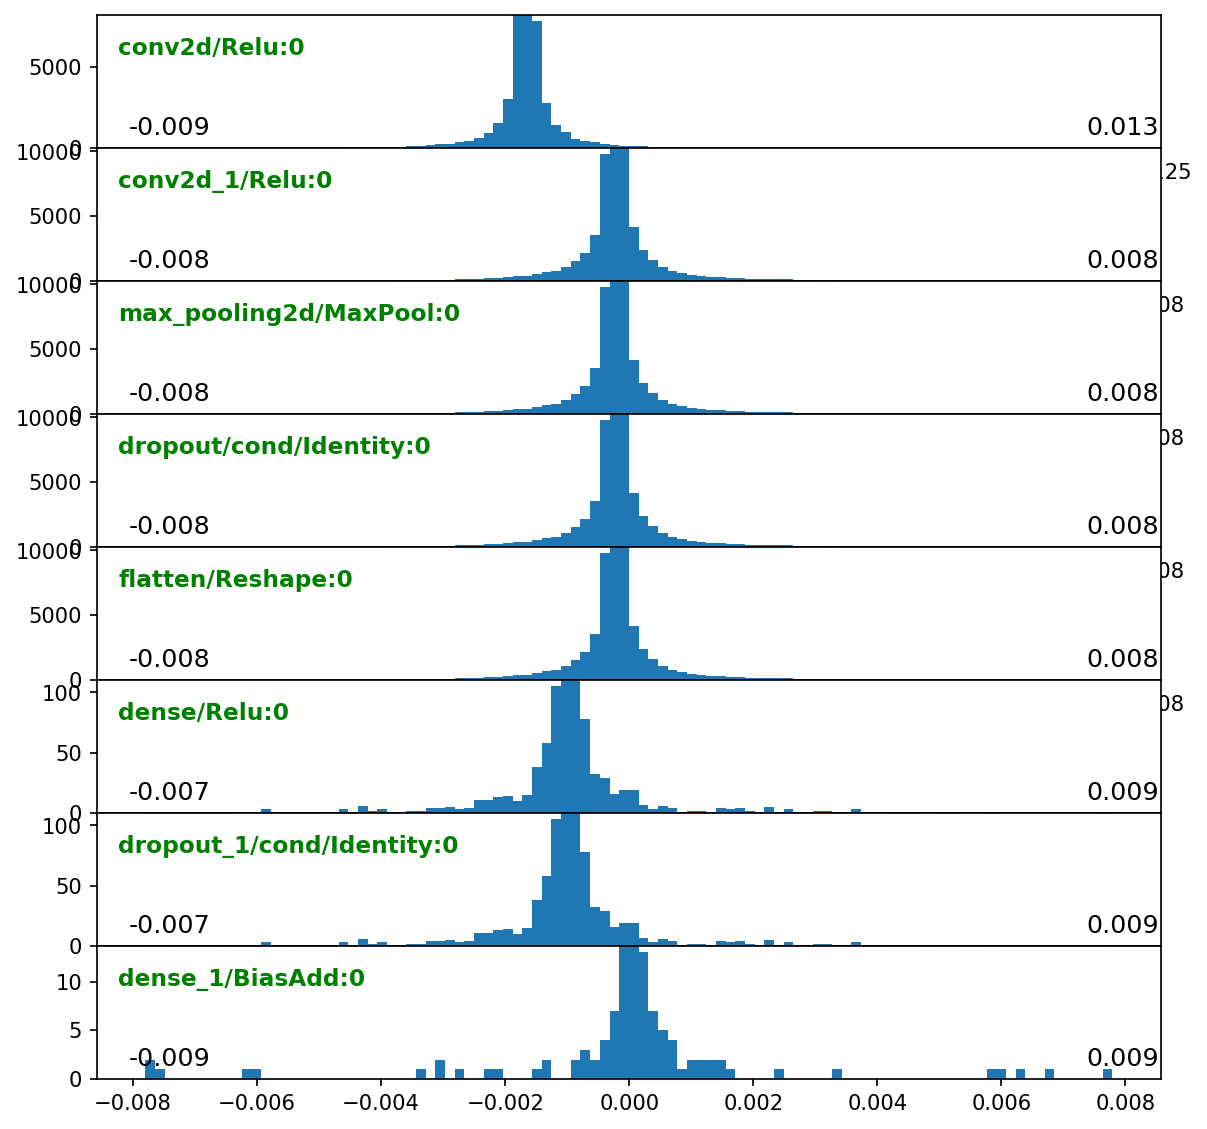

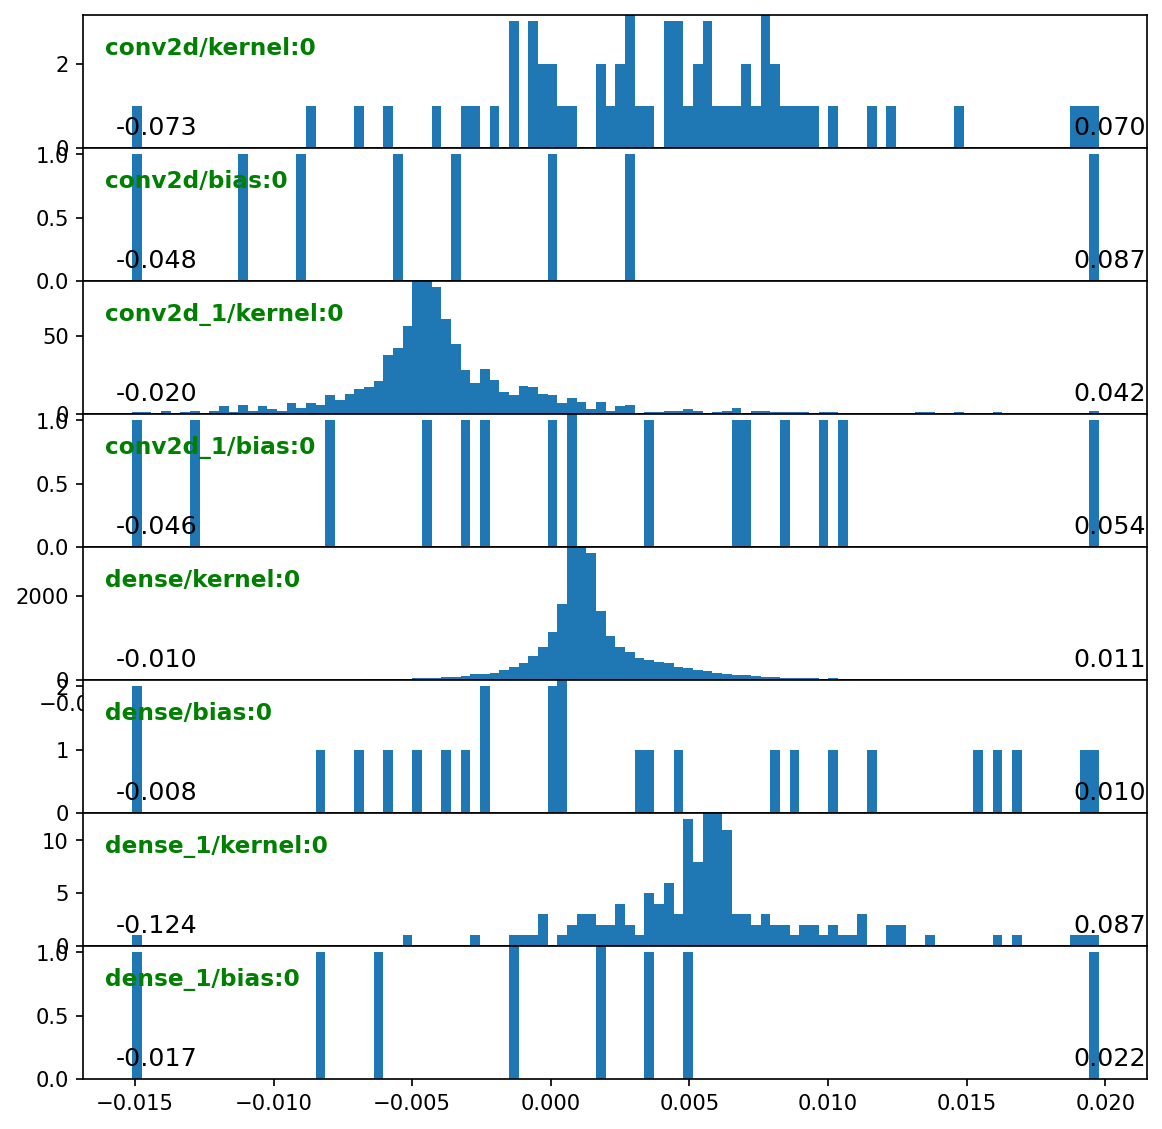

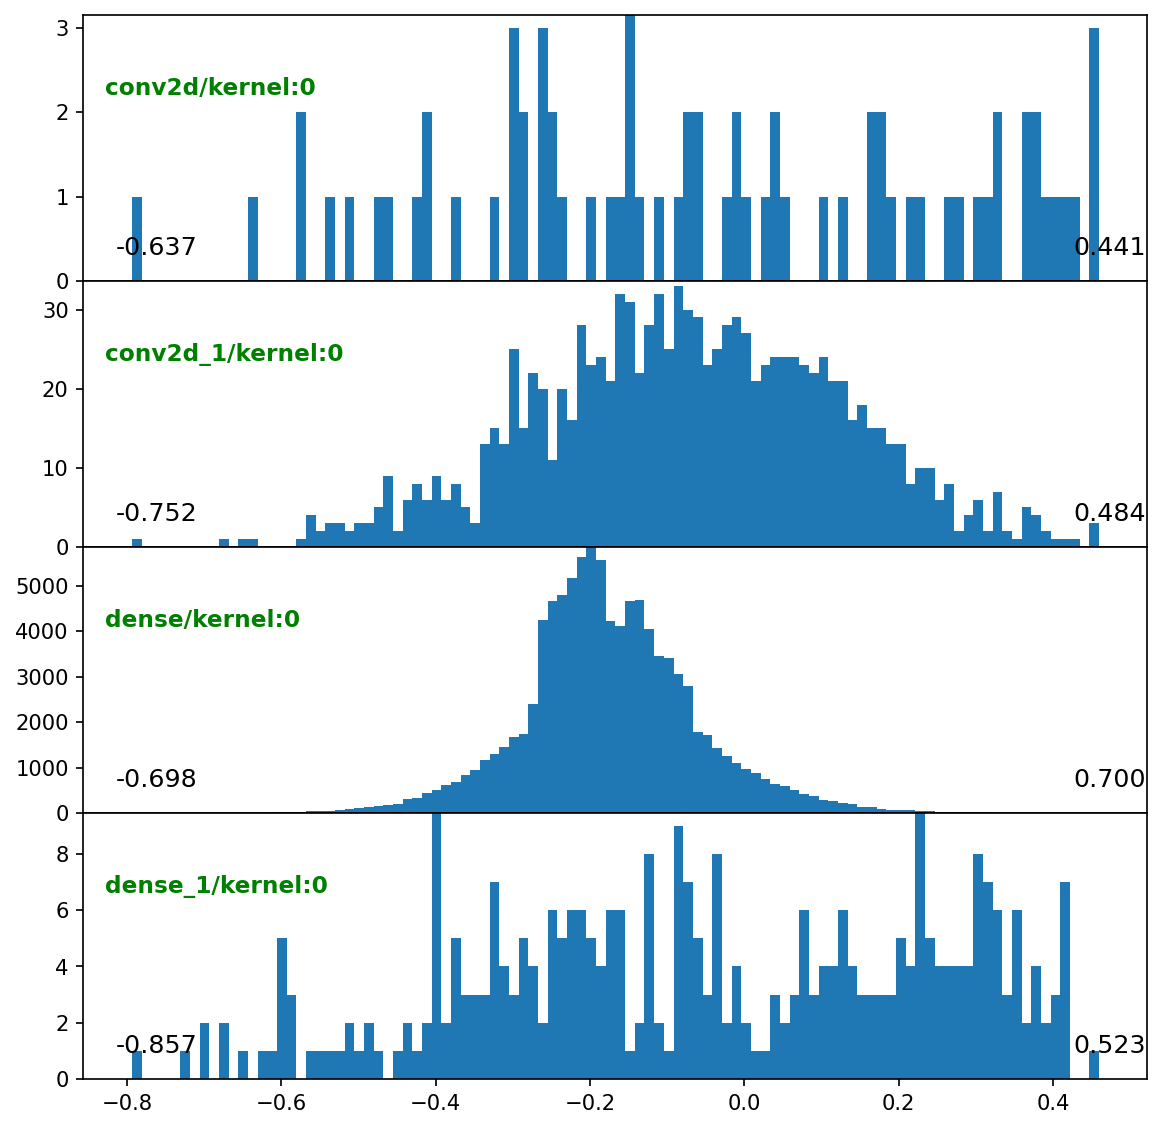

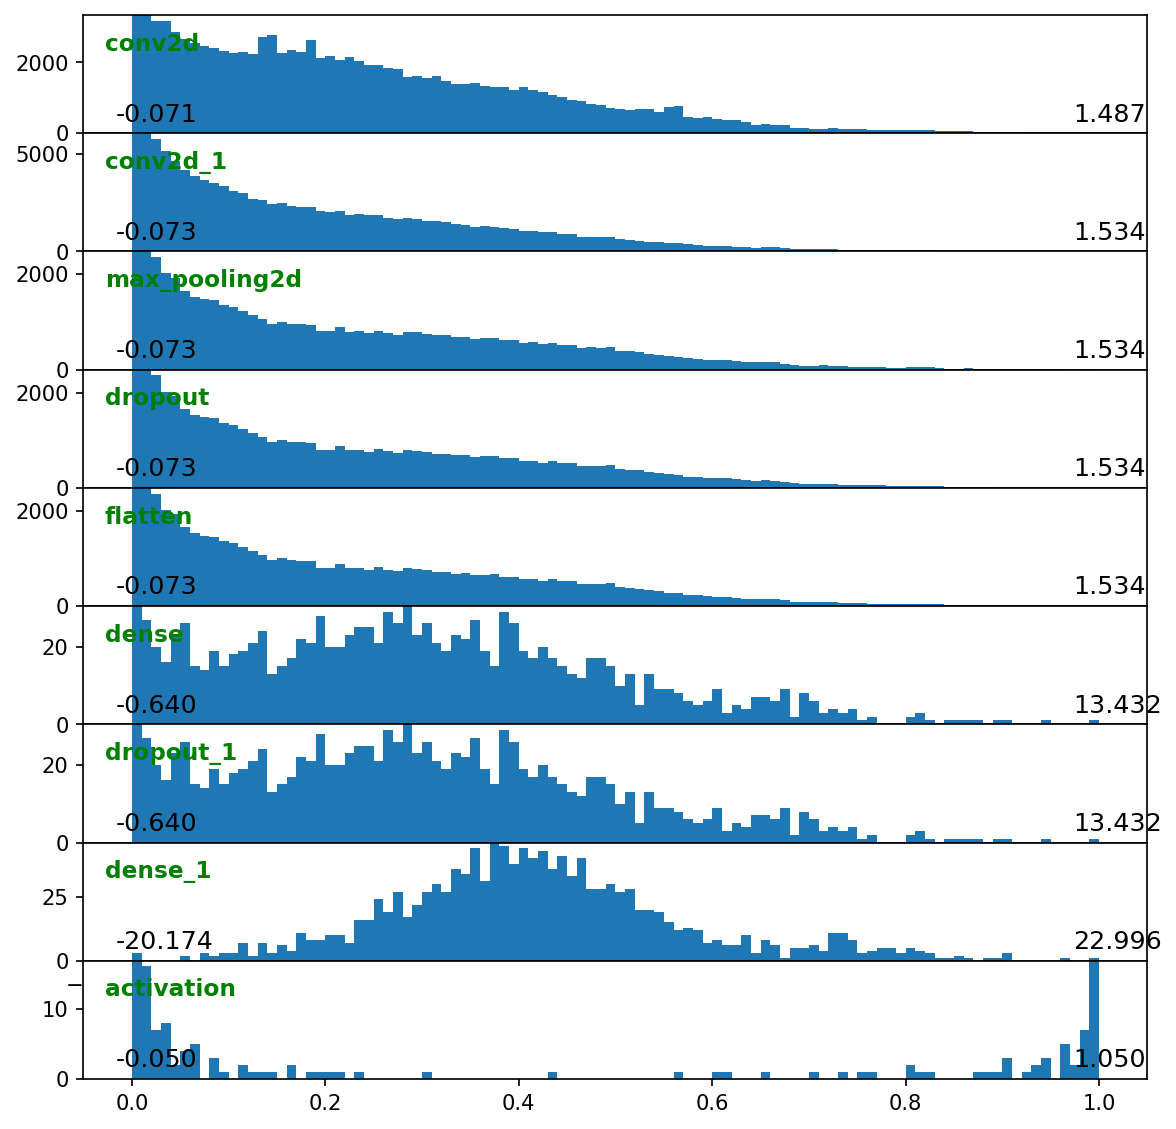

Training has concluded.


In [6]:
tg.train()

We can thus track the progression of layer gradients & activations epoch-to-epoch.

`examples/callbacks/mnist.py` shows an additional callback; notebook shortened.